In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing import image
from keras.utils import np_utils
from keras.applications import VGG16
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [5]:
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [6]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [2]:
train_data = pd.read_csv('train.csv')
test_data =  pd.read_csv('test.csv')

In [3]:
def append_ext(fn):
    return fn+".jpg"

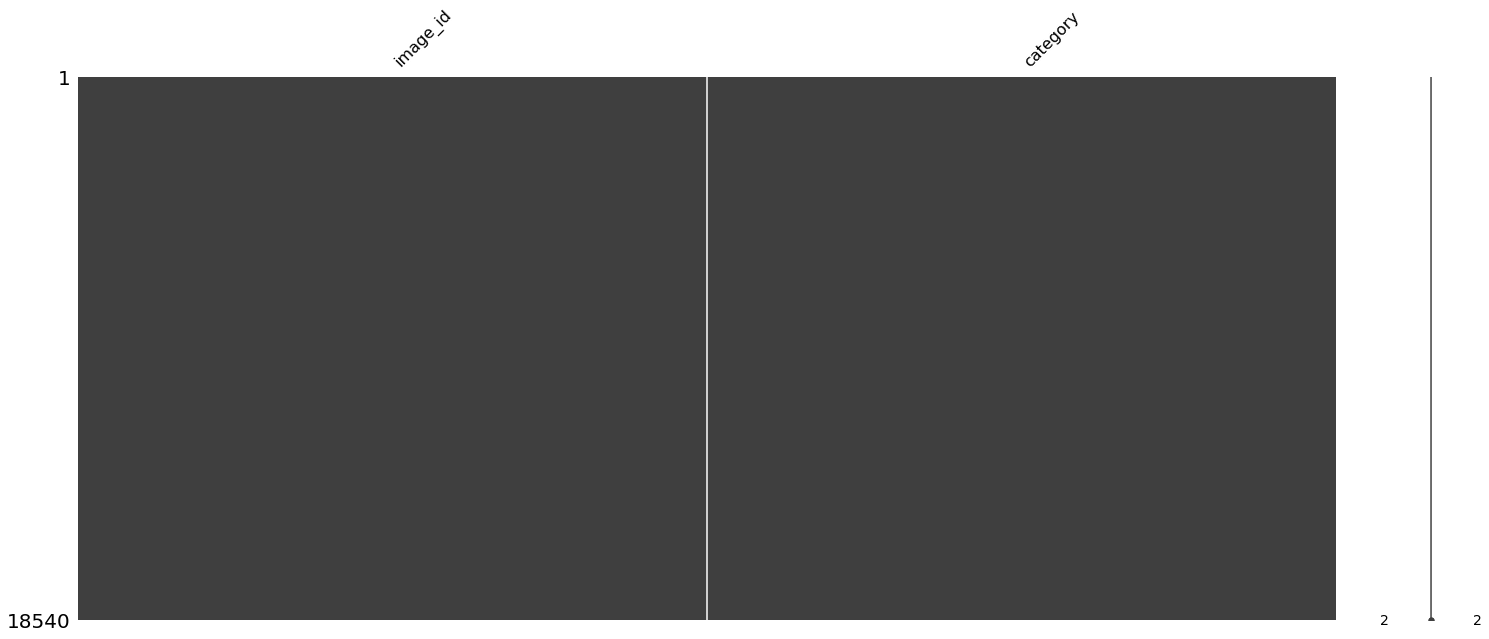

In [6]:
train_data['category'] = train_data['category'].astype(str)
train_data['image_id'] = train_data['image_id'].astype(str).apply(append_ext)
train_data['image_id'] = train_data['image_id'].astype(str)
train_data

import missingno as msno 
  

  # Visualize missing values as a matrix 
msno.matrix(train_data) 

In [22]:
test_data['category'] = test_data['category'].astype(str)
test_data['image_id'] = test_data['image_id'].astype(str).apply(append_ext)
test_data['image_id'] = test_data['image_id'].astype(str)

test_data.head()

,image_id,category
0,18540.jpg,nan
1,18541.jpg,nan
2,18542.jpg,nan
3,18543.jpg,nan
4,18544.jpg,nan


## Transfer Learning using VGG16 Approach 1

In [60]:
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.25)
test_datagen=ImageDataGenerator(rescale=1./255.)

batch_size = 20

def extract_features(df, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count,102))
    generator = test_datagen.flow_from_dataframe(dataframe= df, 
                        directory="./test/", 
                        x_col='image_id', 
                        y_col='category', 
                        target_size=(150, 150), 
                        class_mode='categorical', 
                        batch_size=batch_size)
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = vgg16_model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [11]:
train_features, train_labels = extract_features(train_data, 18540)

Found 18540 validated image filenames belonging to 102 classes.


In [24]:
test_features, test_labels = extract_features(test_data, 2009)

Found 2009 validated image filenames belonging to 1 classes.


In [25]:
train_features = np.reshape(train_features, (18540, 4*4* 512))
test_features =  np.reshape(test_features,  (2009, 4*4* 512))

In [40]:
model = Sequential()
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(102, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['acc'])

In [41]:
history = model.fit(train_features, 
                    train_labels,
                    epochs=30,
                    batch_size=20,
                    )

Epoch 1/30


 4080/18540 [=====>........................] - ETA: 10:39 - loss: 4.6782 - acc: 0.05 - ETA: 5:51 - loss: 6.5561 - acc: 0.0500 - ETA: 4:18 - loss: 6.6071 - acc: 0.033 - ETA: 3:31 - loss: 6.4398 - acc: 0.037 - ETA: 3:04 - loss: 6.3283 - acc: 0.030 - ETA: 2:47 - loss: 6.1385 - acc: 0.025 - ETA: 2:36 - loss: 5.9633 - acc: 0.021 - ETA: 2:27 - loss: 5.8129 - acc: 0.018 - ETA: 2:20 - loss: 5.6901 - acc: 0.022 - ETA: 2:13 - loss: 5.6169 - acc: 0.020 - ETA: 2:08 - loss: 5.5361 - acc: 0.018 - ETA: 2:03 - loss: 5.4708 - acc: 0.016 - ETA: 1:59 - loss: 5.3905 - acc: 0.023 - ETA: 1:55 - loss: 5.3295 - acc: 0.025 - ETA: 1:52 - loss: 5.2912 - acc: 0.026 - ETA: 1:50 - loss: 5.2495 - acc: 0.028 - ETA: 1:47 - loss: 5.2188 - acc: 0.026 - ETA: 1:45 - loss: 5.1763 - acc: 0.030 - ETA: 1:43 - loss: 5.1467 - acc: 0.028 - ETA: 1:42 - loss: 5.1141 - acc: 0.032 - ETA: 1:40 - loss: 5.0758 - acc: 0.035 - ETA: 1:39 - loss: 5.0564 - acc: 0.034 - ETA: 1:38 - loss: 5.0192 - acc: 0.032 - ETA: 1:36 - loss: 5.0049 - acc: 

16980/18540 [==========================>...] - ETA: 21s - loss: 2.9037 - acc: 0.31 - ETA: 21s - loss: 2.9010 - acc: 0.31 - ETA: 21s - loss: 2.8998 - acc: 0.31 - ETA: 21s - loss: 2.8970 - acc: 0.31 - ETA: 21s - loss: 2.8944 - acc: 0.31 - ETA: 21s - loss: 2.8936 - acc: 0.31 - ETA: 21s - loss: 2.8924 - acc: 0.31 - ETA: 21s - loss: 2.8904 - acc: 0.31 - ETA: 21s - loss: 2.8888 - acc: 0.31 - ETA: 21s - loss: 2.8869 - acc: 0.31 - ETA: 21s - loss: 2.8849 - acc: 0.31 - ETA: 21s - loss: 2.8829 - acc: 0.31 - ETA: 21s - loss: 2.8815 - acc: 0.31 - ETA: 21s - loss: 2.8797 - acc: 0.32 - ETA: 20s - loss: 2.8780 - acc: 0.32 - ETA: 20s - loss: 2.8771 - acc: 0.32 - ETA: 20s - loss: 2.8761 - acc: 0.32 - ETA: 20s - loss: 2.8755 - acc: 0.32 - ETA: 20s - loss: 2.8744 - acc: 0.32 - ETA: 20s - loss: 2.8731 - acc: 0.32 - ETA: 20s - loss: 2.8718 - acc: 0.32 - ETA: 20s - loss: 2.8700 - acc: 0.32 - ETA: 20s - loss: 2.8677 - acc: 0.32 - ETA: 20s - loss: 2.8664 - acc: 0.32 - ETA: 20s - loss: 2.8652 - acc: 0.32 - ETA

18540/18540 [==============================] - ETA: 5s - loss: 2.6310 - acc: 0.367 - ETA: 5s - loss: 2.6303 - acc: 0.367 - ETA: 5s - loss: 2.6291 - acc: 0.367 - ETA: 5s - loss: 2.6277 - acc: 0.367 - ETA: 5s - loss: 2.6266 - acc: 0.368 - ETA: 5s - loss: 2.6255 - acc: 0.368 - ETA: 5s - loss: 2.6248 - acc: 0.368 - ETA: 5s - loss: 2.6236 - acc: 0.368 - ETA: 5s - loss: 2.6230 - acc: 0.368 - ETA: 5s - loss: 2.6219 - acc: 0.368 - ETA: 4s - loss: 2.6209 - acc: 0.368 - ETA: 4s - loss: 2.6201 - acc: 0.369 - ETA: 4s - loss: 2.6192 - acc: 0.369 - ETA: 4s - loss: 2.6180 - acc: 0.369 - ETA: 4s - loss: 2.6162 - acc: 0.369 - ETA: 4s - loss: 2.6160 - acc: 0.369 - ETA: 4s - loss: 2.6147 - acc: 0.369 - ETA: 4s - loss: 2.6136 - acc: 0.370 - ETA: 4s - loss: 2.6128 - acc: 0.370 - ETA: 4s - loss: 2.6122 - acc: 0.370 - ETA: 4s - loss: 2.6106 - acc: 0.370 - ETA: 4s - loss: 2.6099 - acc: 0.370 - ETA: 4s - loss: 2.6085 - acc: 0.370 - ETA: 4s - loss: 2.6066 - acc: 0.371 - ETA: 3s - loss: 2.6051 - acc: 0.371 - ETA

 4320/18540 [=====>........................] - ETA: 45s - loss: 1.1345 - acc: 0.70 - ETA: 47s - loss: 1.4043 - acc: 0.65 - ETA: 48s - loss: 1.3789 - acc: 0.63 - ETA: 49s - loss: 1.5253 - acc: 0.57 - ETA: 50s - loss: 1.3683 - acc: 0.60 - ETA: 50s - loss: 1.3962 - acc: 0.59 - ETA: 50s - loss: 1.4045 - acc: 0.58 - ETA: 50s - loss: 1.4566 - acc: 0.58 - ETA: 50s - loss: 1.4278 - acc: 0.58 - ETA: 50s - loss: 1.4438 - acc: 0.58 - ETA: 50s - loss: 1.4703 - acc: 0.58 - ETA: 50s - loss: 1.4361 - acc: 0.58 - ETA: 50s - loss: 1.4539 - acc: 0.57 - ETA: 50s - loss: 1.4584 - acc: 0.57 - ETA: 50s - loss: 1.4486 - acc: 0.58 - ETA: 50s - loss: 1.4245 - acc: 0.59 - ETA: 50s - loss: 1.4025 - acc: 0.60 - ETA: 50s - loss: 1.4353 - acc: 0.59 - ETA: 50s - loss: 1.4128 - acc: 0.60 - ETA: 49s - loss: 1.3969 - acc: 0.61 - ETA: 49s - loss: 1.3923 - acc: 0.60 - ETA: 49s - loss: 1.4199 - acc: 0.60 - ETA: 49s - loss: 1.4103 - acc: 0.60 - ETA: 49s - loss: 1.3998 - acc: 0.60 - ETA: 49s - loss: 1.4121 - acc: 0.60 - ETA

17260/18540 [==========================>...] - ETA: 15s - loss: 1.2873 - acc: 0.64 - ETA: 15s - loss: 1.2880 - acc: 0.64 - ETA: 15s - loss: 1.2879 - acc: 0.64 - ETA: 15s - loss: 1.2888 - acc: 0.64 - ETA: 15s - loss: 1.2874 - acc: 0.64 - ETA: 15s - loss: 1.2869 - acc: 0.64 - ETA: 15s - loss: 1.2861 - acc: 0.64 - ETA: 15s - loss: 1.2873 - acc: 0.64 - ETA: 15s - loss: 1.2870 - acc: 0.64 - ETA: 15s - loss: 1.2878 - acc: 0.64 - ETA: 15s - loss: 1.2882 - acc: 0.64 - ETA: 15s - loss: 1.2878 - acc: 0.64 - ETA: 15s - loss: 1.2876 - acc: 0.64 - ETA: 15s - loss: 1.2872 - acc: 0.64 - ETA: 14s - loss: 1.2875 - acc: 0.64 - ETA: 14s - loss: 1.2867 - acc: 0.64 - ETA: 14s - loss: 1.2863 - acc: 0.64 - ETA: 14s - loss: 1.2866 - acc: 0.64 - ETA: 14s - loss: 1.2865 - acc: 0.64 - ETA: 14s - loss: 1.2858 - acc: 0.64 - ETA: 14s - loss: 1.2854 - acc: 0.64 - ETA: 14s - loss: 1.2856 - acc: 0.64 - ETA: 14s - loss: 1.2860 - acc: 0.64 - ETA: 14s - loss: 1.2861 - acc: 0.64 - ETA: 14s - loss: 1.2859 - acc: 0.64 - ETA

18540/18540 [==============================] - ETA: 3s - loss: 1.2533 - acc: 0.655 - ETA: 3s - loss: 1.2530 - acc: 0.655 - ETA: 3s - loss: 1.2526 - acc: 0.655 - ETA: 3s - loss: 1.2521 - acc: 0.655 - ETA: 3s - loss: 1.2532 - acc: 0.655 - ETA: 3s - loss: 1.2522 - acc: 0.655 - ETA: 3s - loss: 1.2525 - acc: 0.655 - ETA: 3s - loss: 1.2520 - acc: 0.655 - ETA: 3s - loss: 1.2517 - acc: 0.655 - ETA: 3s - loss: 1.2513 - acc: 0.655 - ETA: 2s - loss: 1.2522 - acc: 0.655 - ETA: 2s - loss: 1.2515 - acc: 0.655 - ETA: 2s - loss: 1.2507 - acc: 0.655 - ETA: 2s - loss: 1.2509 - acc: 0.655 - ETA: 2s - loss: 1.2514 - acc: 0.655 - ETA: 2s - loss: 1.2530 - acc: 0.655 - ETA: 2s - loss: 1.2531 - acc: 0.655 - ETA: 2s - loss: 1.2533 - acc: 0.655 - ETA: 2s - loss: 1.2543 - acc: 0.655 - ETA: 2s - loss: 1.2540 - acc: 0.655 - ETA: 2s - loss: 1.2540 - acc: 0.655 - ETA: 2s - loss: 1.2534 - acc: 0.655 - ETA: 2s - loss: 1.2533 - acc: 0.655 - ETA: 2s - loss: 1.2532 - acc: 0.655 - ETA: 2s - loss: 1.2531 - acc: 0.655 - ETA

 4400/18540 [======>.......................] - ETA: 51s - loss: 1.1005 - acc: 0.75 - ETA: 53s - loss: 0.7852 - acc: 0.80 - ETA: 54s - loss: 0.6052 - acc: 0.85 - ETA: 55s - loss: 0.6341 - acc: 0.85 - ETA: 55s - loss: 0.7275 - acc: 0.80 - ETA: 55s - loss: 0.7724 - acc: 0.77 - ETA: 55s - loss: 0.8201 - acc: 0.76 - ETA: 55s - loss: 0.8293 - acc: 0.76 - ETA: 54s - loss: 0.8669 - acc: 0.75 - ETA: 54s - loss: 0.8877 - acc: 0.75 - ETA: 53s - loss: 0.8611 - acc: 0.75 - ETA: 53s - loss: 0.8494 - acc: 0.75 - ETA: 53s - loss: 0.8483 - acc: 0.75 - ETA: 53s - loss: 0.8572 - acc: 0.74 - ETA: 52s - loss: 0.8648 - acc: 0.74 - ETA: 52s - loss: 0.8651 - acc: 0.74 - ETA: 52s - loss: 0.8714 - acc: 0.74 - ETA: 52s - loss: 0.8541 - acc: 0.74 - ETA: 51s - loss: 0.8666 - acc: 0.74 - ETA: 51s - loss: 0.8700 - acc: 0.74 - ETA: 51s - loss: 0.8728 - acc: 0.73 - ETA: 51s - loss: 0.8733 - acc: 0.73 - ETA: 51s - loss: 0.8930 - acc: 0.73 - ETA: 51s - loss: 0.8763 - acc: 0.73 - ETA: 51s - loss: 0.8695 - acc: 0.73 - ETA

17360/18540 [===========================>..] - ETA: 15s - loss: 0.8811 - acc: 0.74 - ETA: 15s - loss: 0.8815 - acc: 0.74 - ETA: 15s - loss: 0.8813 - acc: 0.74 - ETA: 15s - loss: 0.8815 - acc: 0.74 - ETA: 15s - loss: 0.8819 - acc: 0.74 - ETA: 15s - loss: 0.8814 - acc: 0.74 - ETA: 15s - loss: 0.8817 - acc: 0.74 - ETA: 14s - loss: 0.8812 - acc: 0.74 - ETA: 14s - loss: 0.8808 - acc: 0.74 - ETA: 14s - loss: 0.8816 - acc: 0.74 - ETA: 14s - loss: 0.8812 - acc: 0.74 - ETA: 14s - loss: 0.8812 - acc: 0.74 - ETA: 14s - loss: 0.8815 - acc: 0.74 - ETA: 14s - loss: 0.8815 - acc: 0.74 - ETA: 14s - loss: 0.8820 - acc: 0.74 - ETA: 14s - loss: 0.8825 - acc: 0.74 - ETA: 14s - loss: 0.8844 - acc: 0.74 - ETA: 14s - loss: 0.8864 - acc: 0.74 - ETA: 14s - loss: 0.8866 - acc: 0.74 - ETA: 14s - loss: 0.8867 - acc: 0.74 - ETA: 14s - loss: 0.8865 - acc: 0.74 - ETA: 14s - loss: 0.8868 - acc: 0.74 - ETA: 14s - loss: 0.8860 - acc: 0.74 - ETA: 14s - loss: 0.8859 - acc: 0.74 - ETA: 14s - loss: 0.8860 - acc: 0.74 - ETA

18540/18540 [==============================] - ETA: 3s - loss: 0.8756 - acc: 0.745 - ETA: 3s - loss: 0.8763 - acc: 0.745 - ETA: 3s - loss: 0.8761 - acc: 0.745 - ETA: 3s - loss: 0.8760 - acc: 0.745 - ETA: 3s - loss: 0.8757 - acc: 0.745 - ETA: 2s - loss: 0.8756 - acc: 0.745 - ETA: 2s - loss: 0.8758 - acc: 0.745 - ETA: 2s - loss: 0.8756 - acc: 0.745 - ETA: 2s - loss: 0.8753 - acc: 0.745 - ETA: 2s - loss: 0.8751 - acc: 0.745 - ETA: 2s - loss: 0.8754 - acc: 0.745 - ETA: 2s - loss: 0.8756 - acc: 0.745 - ETA: 2s - loss: 0.8755 - acc: 0.745 - ETA: 2s - loss: 0.8751 - acc: 0.745 - ETA: 2s - loss: 0.8753 - acc: 0.745 - ETA: 2s - loss: 0.8750 - acc: 0.745 - ETA: 2s - loss: 0.8747 - acc: 0.745 - ETA: 2s - loss: 0.8751 - acc: 0.745 - ETA: 2s - loss: 0.8748 - acc: 0.745 - ETA: 2s - loss: 0.8754 - acc: 0.745 - ETA: 2s - loss: 0.8754 - acc: 0.745 - ETA: 2s - loss: 0.8753 - acc: 0.745 - ETA: 2s - loss: 0.8758 - acc: 0.745 - ETA: 1s - loss: 0.8757 - acc: 0.745 - ETA: 1s - loss: 0.8763 - acc: 0.745 - ETA

 4420/18540 [======>.......................] - ETA: 51s - loss: 0.5637 - acc: 0.85 - ETA: 52s - loss: 0.5350 - acc: 0.85 - ETA: 52s - loss: 0.4824 - acc: 0.86 - ETA: 52s - loss: 0.4364 - acc: 0.87 - ETA: 51s - loss: 0.4496 - acc: 0.87 - ETA: 51s - loss: 0.4959 - acc: 0.86 - ETA: 51s - loss: 0.5417 - acc: 0.85 - ETA: 52s - loss: 0.5744 - acc: 0.85 - ETA: 52s - loss: 0.5642 - acc: 0.83 - ETA: 51s - loss: 0.5853 - acc: 0.82 - ETA: 51s - loss: 0.5930 - acc: 0.81 - ETA: 52s - loss: 0.5890 - acc: 0.81 - ETA: 52s - loss: 0.5636 - acc: 0.82 - ETA: 52s - loss: 0.5341 - acc: 0.83 - ETA: 52s - loss: 0.5160 - acc: 0.84 - ETA: 52s - loss: 0.5241 - acc: 0.84 - ETA: 52s - loss: 0.5385 - acc: 0.83 - ETA: 51s - loss: 0.5267 - acc: 0.83 - ETA: 51s - loss: 0.5310 - acc: 0.84 - ETA: 51s - loss: 0.5239 - acc: 0.84 - ETA: 51s - loss: 0.5323 - acc: 0.84 - ETA: 51s - loss: 0.5525 - acc: 0.84 - ETA: 51s - loss: 0.5606 - acc: 0.83 - ETA: 51s - loss: 0.5577 - acc: 0.83 - ETA: 51s - loss: 0.5564 - acc: 0.83 - ETA

17480/18540 [===========================>..] - ETA: 15s - loss: 0.6840 - acc: 0.79 - ETA: 15s - loss: 0.6842 - acc: 0.79 - ETA: 15s - loss: 0.6844 - acc: 0.79 - ETA: 15s - loss: 0.6846 - acc: 0.79 - ETA: 15s - loss: 0.6849 - acc: 0.79 - ETA: 14s - loss: 0.6853 - acc: 0.79 - ETA: 14s - loss: 0.6848 - acc: 0.79 - ETA: 14s - loss: 0.6855 - acc: 0.79 - ETA: 14s - loss: 0.6853 - acc: 0.79 - ETA: 14s - loss: 0.6855 - acc: 0.79 - ETA: 14s - loss: 0.6851 - acc: 0.79 - ETA: 14s - loss: 0.6862 - acc: 0.79 - ETA: 14s - loss: 0.6853 - acc: 0.79 - ETA: 14s - loss: 0.6861 - acc: 0.79 - ETA: 14s - loss: 0.6862 - acc: 0.79 - ETA: 14s - loss: 0.6860 - acc: 0.79 - ETA: 14s - loss: 0.6858 - acc: 0.79 - ETA: 14s - loss: 0.6860 - acc: 0.79 - ETA: 14s - loss: 0.6859 - acc: 0.79 - ETA: 14s - loss: 0.6860 - acc: 0.79 - ETA: 14s - loss: 0.6859 - acc: 0.79 - ETA: 14s - loss: 0.6862 - acc: 0.79 - ETA: 14s - loss: 0.6862 - acc: 0.79 - ETA: 13s - loss: 0.6866 - acc: 0.79 - ETA: 13s - loss: 0.6859 - acc: 0.79 - ETA

18540/18540 [==============================] - ETA: 2s - loss: 0.6851 - acc: 0.793 - ETA: 2s - loss: 0.6846 - acc: 0.793 - ETA: 2s - loss: 0.6851 - acc: 0.793 - ETA: 2s - loss: 0.6851 - acc: 0.793 - ETA: 2s - loss: 0.6848 - acc: 0.793 - ETA: 2s - loss: 0.6847 - acc: 0.793 - ETA: 2s - loss: 0.6849 - acc: 0.793 - ETA: 2s - loss: 0.6847 - acc: 0.793 - ETA: 2s - loss: 0.6848 - acc: 0.793 - ETA: 2s - loss: 0.6846 - acc: 0.793 - ETA: 2s - loss: 0.6849 - acc: 0.793 - ETA: 2s - loss: 0.6846 - acc: 0.793 - ETA: 2s - loss: 0.6847 - acc: 0.793 - ETA: 2s - loss: 0.6845 - acc: 0.793 - ETA: 2s - loss: 0.6845 - acc: 0.793 - ETA: 2s - loss: 0.6840 - acc: 0.793 - ETA: 2s - loss: 0.6840 - acc: 0.793 - ETA: 1s - loss: 0.6848 - acc: 0.793 - ETA: 1s - loss: 0.6846 - acc: 0.793 - ETA: 1s - loss: 0.6842 - acc: 0.793 - ETA: 1s - loss: 0.6848 - acc: 0.793 - ETA: 1s - loss: 0.6850 - acc: 0.793 - ETA: 1s - loss: 0.6846 - acc: 0.793 - ETA: 1s - loss: 0.6842 - acc: 0.793 - ETA: 1s - loss: 0.6842 - acc: 0.793 - ETA

 4360/18540 [======>.......................] - ETA: 47s - loss: 0.7424 - acc: 0.70 - ETA: 48s - loss: 0.6035 - acc: 0.77 - ETA: 48s - loss: 0.5957 - acc: 0.78 - ETA: 49s - loss: 0.5407 - acc: 0.78 - ETA: 50s - loss: 0.5363 - acc: 0.79 - ETA: 50s - loss: 0.5400 - acc: 0.79 - ETA: 49s - loss: 0.5168 - acc: 0.80 - ETA: 49s - loss: 0.5360 - acc: 0.79 - ETA: 49s - loss: 0.5192 - acc: 0.80 - ETA: 50s - loss: 0.5434 - acc: 0.81 - ETA: 49s - loss: 0.5661 - acc: 0.79 - ETA: 50s - loss: 0.5827 - acc: 0.80 - ETA: 49s - loss: 0.5962 - acc: 0.79 - ETA: 50s - loss: 0.6160 - acc: 0.78 - ETA: 50s - loss: 0.6073 - acc: 0.78 - ETA: 50s - loss: 0.5809 - acc: 0.79 - ETA: 50s - loss: 0.5566 - acc: 0.80 - ETA: 50s - loss: 0.5514 - acc: 0.80 - ETA: 49s - loss: 0.5304 - acc: 0.81 - ETA: 49s - loss: 0.5440 - acc: 0.81 - ETA: 50s - loss: 0.5546 - acc: 0.80 - ETA: 50s - loss: 0.5559 - acc: 0.80 - ETA: 49s - loss: 0.5614 - acc: 0.81 - ETA: 49s - loss: 0.5534 - acc: 0.81 - ETA: 49s - loss: 0.5684 - acc: 0.81 - ETA

17440/18540 [===========================>..] - ETA: 15s - loss: 0.5720 - acc: 0.82 - ETA: 15s - loss: 0.5728 - acc: 0.82 - ETA: 15s - loss: 0.5726 - acc: 0.82 - ETA: 14s - loss: 0.5721 - acc: 0.82 - ETA: 14s - loss: 0.5729 - acc: 0.82 - ETA: 14s - loss: 0.5730 - acc: 0.82 - ETA: 14s - loss: 0.5725 - acc: 0.82 - ETA: 14s - loss: 0.5722 - acc: 0.82 - ETA: 14s - loss: 0.5720 - acc: 0.82 - ETA: 14s - loss: 0.5722 - acc: 0.82 - ETA: 14s - loss: 0.5726 - acc: 0.82 - ETA: 14s - loss: 0.5732 - acc: 0.82 - ETA: 14s - loss: 0.5732 - acc: 0.82 - ETA: 14s - loss: 0.5729 - acc: 0.82 - ETA: 14s - loss: 0.5727 - acc: 0.82 - ETA: 14s - loss: 0.5731 - acc: 0.82 - ETA: 14s - loss: 0.5724 - acc: 0.82 - ETA: 14s - loss: 0.5725 - acc: 0.82 - ETA: 14s - loss: 0.5724 - acc: 0.82 - ETA: 14s - loss: 0.5723 - acc: 0.82 - ETA: 14s - loss: 0.5725 - acc: 0.82 - ETA: 13s - loss: 0.5721 - acc: 0.82 - ETA: 13s - loss: 0.5730 - acc: 0.82 - ETA: 13s - loss: 0.5728 - acc: 0.82 - ETA: 13s - loss: 0.5722 - acc: 0.82 - ETA

18540/18540 [==============================] - ETA: 2s - loss: 0.5785 - acc: 0.828 - ETA: 2s - loss: 0.5780 - acc: 0.828 - ETA: 2s - loss: 0.5782 - acc: 0.828 - ETA: 2s - loss: 0.5784 - acc: 0.828 - ETA: 2s - loss: 0.5784 - acc: 0.828 - ETA: 2s - loss: 0.5782 - acc: 0.828 - ETA: 2s - loss: 0.5777 - acc: 0.828 - ETA: 2s - loss: 0.5779 - acc: 0.828 - ETA: 2s - loss: 0.5778 - acc: 0.828 - ETA: 2s - loss: 0.5773 - acc: 0.828 - ETA: 2s - loss: 0.5773 - acc: 0.828 - ETA: 2s - loss: 0.5772 - acc: 0.828 - ETA: 2s - loss: 0.5777 - acc: 0.828 - ETA: 2s - loss: 0.5773 - acc: 0.828 - ETA: 2s - loss: 0.5771 - acc: 0.828 - ETA: 2s - loss: 0.5774 - acc: 0.828 - ETA: 2s - loss: 0.5775 - acc: 0.828 - ETA: 2s - loss: 0.5769 - acc: 0.828 - ETA: 1s - loss: 0.5777 - acc: 0.828 - ETA: 1s - loss: 0.5777 - acc: 0.828 - ETA: 1s - loss: 0.5782 - acc: 0.828 - ETA: 1s - loss: 0.5791 - acc: 0.828 - ETA: 1s - loss: 0.5794 - acc: 0.828 - ETA: 1s - loss: 0.5797 - acc: 0.828 - ETA: 1s - loss: 0.5801 - acc: 0.828 - ETA

 4340/18540 [======>.......................] - ETA: 47s - loss: 0.0537 - acc: 1.00 - ETA: 50s - loss: 0.1781 - acc: 0.97 - ETA: 51s - loss: 0.1959 - acc: 0.95 - ETA: 55s - loss: 0.2596 - acc: 0.92 - ETA: 57s - loss: 0.2881 - acc: 0.91 - ETA: 59s - loss: 0.3468 - acc: 0.89 - ETA: 1:00 - loss: 0.3869 - acc: 0.885 - ETA: 1:00 - loss: 0.3831 - acc: 0.887 - ETA: 1:00 - loss: 0.3752 - acc: 0.883 - ETA: 59s - loss: 0.3684 - acc: 0.880 - ETA: 58s - loss: 0.3784 - acc: 0.88 - ETA: 57s - loss: 0.3904 - acc: 0.88 - ETA: 57s - loss: 0.4210 - acc: 0.87 - ETA: 56s - loss: 0.4338 - acc: 0.87 - ETA: 56s - loss: 0.4337 - acc: 0.87 - ETA: 55s - loss: 0.4223 - acc: 0.87 - ETA: 55s - loss: 0.4102 - acc: 0.88 - ETA: 54s - loss: 0.4116 - acc: 0.88 - ETA: 54s - loss: 0.4298 - acc: 0.87 - ETA: 54s - loss: 0.4300 - acc: 0.87 - ETA: 53s - loss: 0.4234 - acc: 0.87 - ETA: 53s - loss: 0.4356 - acc: 0.87 - ETA: 53s - loss: 0.4326 - acc: 0.86 - ETA: 53s - loss: 0.4229 - acc: 0.87 - ETA: 53s - loss: 0.4348 - acc: 0.8

17460/18540 [===========================>..] - ETA: 15s - loss: 0.4985 - acc: 0.85 - ETA: 15s - loss: 0.4981 - acc: 0.85 - ETA: 15s - loss: 0.4978 - acc: 0.85 - ETA: 15s - loss: 0.4981 - acc: 0.85 - ETA: 14s - loss: 0.4985 - acc: 0.85 - ETA: 14s - loss: 0.4983 - acc: 0.85 - ETA: 14s - loss: 0.4985 - acc: 0.85 - ETA: 14s - loss: 0.4986 - acc: 0.85 - ETA: 14s - loss: 0.4987 - acc: 0.85 - ETA: 14s - loss: 0.4987 - acc: 0.85 - ETA: 14s - loss: 0.4990 - acc: 0.85 - ETA: 14s - loss: 0.4994 - acc: 0.85 - ETA: 14s - loss: 0.4997 - acc: 0.85 - ETA: 14s - loss: 0.4996 - acc: 0.85 - ETA: 14s - loss: 0.4994 - acc: 0.85 - ETA: 14s - loss: 0.4997 - acc: 0.85 - ETA: 14s - loss: 0.5000 - acc: 0.85 - ETA: 14s - loss: 0.4995 - acc: 0.85 - ETA: 14s - loss: 0.4991 - acc: 0.85 - ETA: 14s - loss: 0.4993 - acc: 0.85 - ETA: 14s - loss: 0.4987 - acc: 0.85 - ETA: 14s - loss: 0.4990 - acc: 0.85 - ETA: 13s - loss: 0.4988 - acc: 0.85 - ETA: 13s - loss: 0.4987 - acc: 0.85 - ETA: 13s - loss: 0.4986 - acc: 0.85 - ETA

18540/18540 [==============================] - ETA: 2s - loss: 0.5012 - acc: 0.849 - ETA: 2s - loss: 0.5010 - acc: 0.849 - ETA: 2s - loss: 0.5012 - acc: 0.849 - ETA: 2s - loss: 0.5010 - acc: 0.849 - ETA: 2s - loss: 0.5007 - acc: 0.849 - ETA: 2s - loss: 0.5004 - acc: 0.849 - ETA: 2s - loss: 0.5003 - acc: 0.849 - ETA: 2s - loss: 0.5005 - acc: 0.849 - ETA: 2s - loss: 0.5002 - acc: 0.849 - ETA: 2s - loss: 0.4998 - acc: 0.850 - ETA: 2s - loss: 0.5000 - acc: 0.850 - ETA: 2s - loss: 0.5000 - acc: 0.850 - ETA: 2s - loss: 0.4998 - acc: 0.850 - ETA: 2s - loss: 0.4996 - acc: 0.850 - ETA: 2s - loss: 0.4993 - acc: 0.850 - ETA: 2s - loss: 0.4991 - acc: 0.850 - ETA: 2s - loss: 0.4990 - acc: 0.850 - ETA: 2s - loss: 0.4993 - acc: 0.850 - ETA: 1s - loss: 0.4992 - acc: 0.850 - ETA: 1s - loss: 0.4997 - acc: 0.850 - ETA: 1s - loss: 0.4997 - acc: 0.850 - ETA: 1s - loss: 0.4995 - acc: 0.850 - ETA: 1s - loss: 0.4996 - acc: 0.850 - ETA: 1s - loss: 0.4997 - acc: 0.850 - ETA: 1s - loss: 0.4997 - acc: 0.850 - ETA

 4340/18540 [======>.......................] - ETA: 48s - loss: 0.1655 - acc: 0.95 - ETA: 51s - loss: 0.2570 - acc: 0.90 - ETA: 51s - loss: 0.2389 - acc: 0.91 - ETA: 51s - loss: 0.2989 - acc: 0.90 - ETA: 51s - loss: 0.4459 - acc: 0.86 - ETA: 51s - loss: 0.3959 - acc: 0.87 - ETA: 51s - loss: 0.3793 - acc: 0.87 - ETA: 52s - loss: 0.3650 - acc: 0.88 - ETA: 51s - loss: 0.3841 - acc: 0.88 - ETA: 51s - loss: 0.3653 - acc: 0.89 - ETA: 51s - loss: 0.3386 - acc: 0.90 - ETA: 51s - loss: 0.3308 - acc: 0.90 - ETA: 51s - loss: 0.3309 - acc: 0.90 - ETA: 51s - loss: 0.3269 - acc: 0.90 - ETA: 51s - loss: 0.3162 - acc: 0.90 - ETA: 51s - loss: 0.3332 - acc: 0.90 - ETA: 51s - loss: 0.3309 - acc: 0.90 - ETA: 51s - loss: 0.3488 - acc: 0.89 - ETA: 51s - loss: 0.3350 - acc: 0.89 - ETA: 51s - loss: 0.3389 - acc: 0.89 - ETA: 51s - loss: 0.3377 - acc: 0.89 - ETA: 51s - loss: 0.3399 - acc: 0.89 - ETA: 51s - loss: 0.3386 - acc: 0.89 - ETA: 51s - loss: 0.3344 - acc: 0.89 - ETA: 51s - loss: 0.3272 - acc: 0.90 - ETA

17600/18540 [===========================>..] - ETA: 14s - loss: 0.4237 - acc: 0.87 - ETA: 14s - loss: 0.4236 - acc: 0.87 - ETA: 14s - loss: 0.4239 - acc: 0.87 - ETA: 14s - loss: 0.4237 - acc: 0.87 - ETA: 14s - loss: 0.4235 - acc: 0.87 - ETA: 14s - loss: 0.4233 - acc: 0.87 - ETA: 14s - loss: 0.4234 - acc: 0.87 - ETA: 14s - loss: 0.4235 - acc: 0.87 - ETA: 14s - loss: 0.4232 - acc: 0.87 - ETA: 14s - loss: 0.4242 - acc: 0.87 - ETA: 14s - loss: 0.4242 - acc: 0.87 - ETA: 14s - loss: 0.4244 - acc: 0.87 - ETA: 14s - loss: 0.4252 - acc: 0.87 - ETA: 14s - loss: 0.4255 - acc: 0.87 - ETA: 14s - loss: 0.4255 - acc: 0.87 - ETA: 14s - loss: 0.4251 - acc: 0.87 - ETA: 13s - loss: 0.4253 - acc: 0.87 - ETA: 13s - loss: 0.4251 - acc: 0.87 - ETA: 13s - loss: 0.4246 - acc: 0.87 - ETA: 13s - loss: 0.4249 - acc: 0.87 - ETA: 13s - loss: 0.4247 - acc: 0.87 - ETA: 13s - loss: 0.4244 - acc: 0.87 - ETA: 13s - loss: 0.4247 - acc: 0.87 - ETA: 13s - loss: 0.4248 - acc: 0.87 - ETA: 13s - loss: 0.4246 - acc: 0.87 - ETA

18540/18540 [==============================] - ETA: 2s - loss: 0.4304 - acc: 0.873 - ETA: 2s - loss: 0.4306 - acc: 0.873 - ETA: 2s - loss: 0.4304 - acc: 0.873 - ETA: 2s - loss: 0.4304 - acc: 0.873 - ETA: 2s - loss: 0.4300 - acc: 0.873 - ETA: 2s - loss: 0.4302 - acc: 0.873 - ETA: 2s - loss: 0.4302 - acc: 0.873 - ETA: 2s - loss: 0.4304 - acc: 0.873 - ETA: 2s - loss: 0.4304 - acc: 0.873 - ETA: 2s - loss: 0.4302 - acc: 0.873 - ETA: 1s - loss: 0.4305 - acc: 0.873 - ETA: 1s - loss: 0.4305 - acc: 0.873 - ETA: 1s - loss: 0.4308 - acc: 0.873 - ETA: 1s - loss: 0.4309 - acc: 0.872 - ETA: 1s - loss: 0.4311 - acc: 0.872 - ETA: 1s - loss: 0.4307 - acc: 0.873 - ETA: 1s - loss: 0.4307 - acc: 0.873 - ETA: 1s - loss: 0.4306 - acc: 0.873 - ETA: 1s - loss: 0.4303 - acc: 0.873 - ETA: 1s - loss: 0.4306 - acc: 0.873 - ETA: 1s - loss: 0.4308 - acc: 0.872 - ETA: 1s - loss: 0.4312 - acc: 0.872 - ETA: 1s - loss: 0.4315 - acc: 0.872 - ETA: 1s - loss: 0.4313 - acc: 0.872 - ETA: 1s - loss: 0.4309 - acc: 0.872 - ETA

 4380/18540 [======>.......................] - ETA: 48s - loss: 0.2022 - acc: 0.95 - ETA: 50s - loss: 0.3028 - acc: 0.90 - ETA: 50s - loss: 0.3378 - acc: 0.86 - ETA: 50s - loss: 0.2995 - acc: 0.86 - ETA: 52s - loss: 0.3123 - acc: 0.86 - ETA: 51s - loss: 0.3336 - acc: 0.87 - ETA: 51s - loss: 0.3011 - acc: 0.88 - ETA: 51s - loss: 0.3254 - acc: 0.86 - ETA: 51s - loss: 0.3515 - acc: 0.87 - ETA: 51s - loss: 0.3939 - acc: 0.86 - ETA: 51s - loss: 0.3879 - acc: 0.86 - ETA: 51s - loss: 0.3841 - acc: 0.87 - ETA: 51s - loss: 0.3665 - acc: 0.87 - ETA: 51s - loss: 0.3440 - acc: 0.88 - ETA: 51s - loss: 0.3486 - acc: 0.88 - ETA: 51s - loss: 0.3407 - acc: 0.88 - ETA: 51s - loss: 0.3240 - acc: 0.89 - ETA: 51s - loss: 0.3175 - acc: 0.89 - ETA: 51s - loss: 0.3081 - acc: 0.89 - ETA: 50s - loss: 0.3040 - acc: 0.89 - ETA: 50s - loss: 0.2963 - acc: 0.90 - ETA: 50s - loss: 0.3041 - acc: 0.90 - ETA: 50s - loss: 0.2954 - acc: 0.90 - ETA: 50s - loss: 0.2967 - acc: 0.90 - ETA: 50s - loss: 0.2887 - acc: 0.90 - ETA

17480/18540 [===========================>..] - ETA: 15s - loss: 0.3900 - acc: 0.88 - ETA: 15s - loss: 0.3895 - acc: 0.88 - ETA: 15s - loss: 0.3900 - acc: 0.88 - ETA: 15s - loss: 0.3912 - acc: 0.88 - ETA: 15s - loss: 0.3909 - acc: 0.88 - ETA: 15s - loss: 0.3907 - acc: 0.88 - ETA: 14s - loss: 0.3904 - acc: 0.88 - ETA: 14s - loss: 0.3903 - acc: 0.88 - ETA: 14s - loss: 0.3909 - acc: 0.88 - ETA: 14s - loss: 0.3907 - acc: 0.88 - ETA: 14s - loss: 0.3901 - acc: 0.88 - ETA: 14s - loss: 0.3904 - acc: 0.88 - ETA: 14s - loss: 0.3907 - acc: 0.88 - ETA: 14s - loss: 0.3908 - acc: 0.88 - ETA: 14s - loss: 0.3907 - acc: 0.88 - ETA: 14s - loss: 0.3906 - acc: 0.88 - ETA: 14s - loss: 0.3902 - acc: 0.88 - ETA: 14s - loss: 0.3901 - acc: 0.88 - ETA: 14s - loss: 0.3916 - acc: 0.88 - ETA: 14s - loss: 0.3918 - acc: 0.88 - ETA: 14s - loss: 0.3917 - acc: 0.88 - ETA: 14s - loss: 0.3921 - acc: 0.88 - ETA: 14s - loss: 0.3919 - acc: 0.88 - ETA: 14s - loss: 0.3917 - acc: 0.88 - ETA: 13s - loss: 0.3914 - acc: 0.88 - ETA

18540/18540 [==============================] - ETA: 2s - loss: 0.3884 - acc: 0.885 - ETA: 2s - loss: 0.3887 - acc: 0.884 - ETA: 2s - loss: 0.3884 - acc: 0.885 - ETA: 2s - loss: 0.3885 - acc: 0.885 - ETA: 2s - loss: 0.3891 - acc: 0.885 - ETA: 2s - loss: 0.3888 - acc: 0.885 - ETA: 2s - loss: 0.3885 - acc: 0.885 - ETA: 2s - loss: 0.3883 - acc: 0.885 - ETA: 2s - loss: 0.3879 - acc: 0.885 - ETA: 2s - loss: 0.3875 - acc: 0.885 - ETA: 2s - loss: 0.3879 - acc: 0.885 - ETA: 2s - loss: 0.3877 - acc: 0.885 - ETA: 2s - loss: 0.3878 - acc: 0.885 - ETA: 2s - loss: 0.3876 - acc: 0.885 - ETA: 2s - loss: 0.3872 - acc: 0.885 - ETA: 2s - loss: 0.3872 - acc: 0.885 - ETA: 1s - loss: 0.3870 - acc: 0.885 - ETA: 1s - loss: 0.3870 - acc: 0.885 - ETA: 1s - loss: 0.3874 - acc: 0.885 - ETA: 1s - loss: 0.3872 - acc: 0.885 - ETA: 1s - loss: 0.3877 - acc: 0.885 - ETA: 1s - loss: 0.3879 - acc: 0.885 - ETA: 1s - loss: 0.3879 - acc: 0.885 - ETA: 1s - loss: 0.3881 - acc: 0.885 - ETA: 1s - loss: 0.3880 - acc: 0.885 - ETA

 4460/18540 [======>.......................] - ETA: 48s - loss: 0.2806 - acc: 0.90 - ETA: 48s - loss: 0.3197 - acc: 0.82 - ETA: 49s - loss: 0.2541 - acc: 0.86 - ETA: 50s - loss: 0.3771 - acc: 0.86 - ETA: 50s - loss: 0.3631 - acc: 0.88 - ETA: 50s - loss: 0.3925 - acc: 0.85 - ETA: 50s - loss: 0.3890 - acc: 0.87 - ETA: 51s - loss: 0.3606 - acc: 0.87 - ETA: 50s - loss: 0.3513 - acc: 0.87 - ETA: 50s - loss: 0.3466 - acc: 0.87 - ETA: 50s - loss: 0.3188 - acc: 0.88 - ETA: 50s - loss: 0.3129 - acc: 0.88 - ETA: 50s - loss: 0.2942 - acc: 0.89 - ETA: 50s - loss: 0.2957 - acc: 0.88 - ETA: 50s - loss: 0.2996 - acc: 0.88 - ETA: 50s - loss: 0.2848 - acc: 0.89 - ETA: 50s - loss: 0.2746 - acc: 0.89 - ETA: 50s - loss: 0.2857 - acc: 0.89 - ETA: 51s - loss: 0.2771 - acc: 0.90 - ETA: 50s - loss: 0.2678 - acc: 0.90 - ETA: 50s - loss: 0.2847 - acc: 0.90 - ETA: 50s - loss: 0.2780 - acc: 0.90 - ETA: 50s - loss: 0.2957 - acc: 0.89 - ETA: 50s - loss: 0.2997 - acc: 0.89 - ETA: 50s - loss: 0.3080 - acc: 0.89 - ETA

17420/18540 [===========================>..] - ETA: 15s - loss: 0.3437 - acc: 0.89 - ETA: 15s - loss: 0.3435 - acc: 0.89 - ETA: 15s - loss: 0.3432 - acc: 0.89 - ETA: 14s - loss: 0.3442 - acc: 0.89 - ETA: 14s - loss: 0.3441 - acc: 0.89 - ETA: 14s - loss: 0.3444 - acc: 0.89 - ETA: 14s - loss: 0.3446 - acc: 0.89 - ETA: 14s - loss: 0.3454 - acc: 0.89 - ETA: 14s - loss: 0.3455 - acc: 0.89 - ETA: 14s - loss: 0.3460 - acc: 0.89 - ETA: 14s - loss: 0.3461 - acc: 0.89 - ETA: 14s - loss: 0.3458 - acc: 0.89 - ETA: 14s - loss: 0.3455 - acc: 0.89 - ETA: 14s - loss: 0.3457 - acc: 0.89 - ETA: 14s - loss: 0.3455 - acc: 0.89 - ETA: 14s - loss: 0.3454 - acc: 0.89 - ETA: 14s - loss: 0.3452 - acc: 0.89 - ETA: 14s - loss: 0.3454 - acc: 0.89 - ETA: 14s - loss: 0.3458 - acc: 0.89 - ETA: 14s - loss: 0.3457 - acc: 0.89 - ETA: 14s - loss: 0.3453 - acc: 0.89 - ETA: 13s - loss: 0.3453 - acc: 0.89 - ETA: 13s - loss: 0.3451 - acc: 0.89 - ETA: 13s - loss: 0.3448 - acc: 0.89 - ETA: 13s - loss: 0.3446 - acc: 0.89 - ETA

18540/18540 [==============================] - ETA: 3s - loss: 0.3472 - acc: 0.896 - ETA: 3s - loss: 0.3472 - acc: 0.897 - ETA: 2s - loss: 0.3468 - acc: 0.897 - ETA: 2s - loss: 0.3473 - acc: 0.897 - ETA: 2s - loss: 0.3470 - acc: 0.897 - ETA: 2s - loss: 0.3471 - acc: 0.897 - ETA: 2s - loss: 0.3470 - acc: 0.897 - ETA: 2s - loss: 0.3467 - acc: 0.897 - ETA: 2s - loss: 0.3471 - acc: 0.897 - ETA: 2s - loss: 0.3470 - acc: 0.897 - ETA: 2s - loss: 0.3467 - acc: 0.897 - ETA: 2s - loss: 0.3475 - acc: 0.897 - ETA: 2s - loss: 0.3476 - acc: 0.897 - ETA: 2s - loss: 0.3479 - acc: 0.896 - ETA: 2s - loss: 0.3477 - acc: 0.896 - ETA: 2s - loss: 0.3480 - acc: 0.896 - ETA: 2s - loss: 0.3482 - acc: 0.896 - ETA: 2s - loss: 0.3480 - acc: 0.896 - ETA: 2s - loss: 0.3484 - acc: 0.896 - ETA: 2s - loss: 0.3481 - acc: 0.896 - ETA: 1s - loss: 0.3480 - acc: 0.896 - ETA: 1s - loss: 0.3480 - acc: 0.896 - ETA: 1s - loss: 0.3479 - acc: 0.896 - ETA: 1s - loss: 0.3477 - acc: 0.896 - ETA: 1s - loss: 0.3473 - acc: 0.897 - ETA

 4360/18540 [======>.......................] - ETA: 48s - loss: 0.0602 - acc: 1.00 - ETA: 49s - loss: 0.1349 - acc: 0.95 - ETA: 50s - loss: 0.3862 - acc: 0.91 - ETA: 50s - loss: 0.3455 - acc: 0.91 - ETA: 51s - loss: 0.3049 - acc: 0.92 - ETA: 50s - loss: 0.2884 - acc: 0.92 - ETA: 50s - loss: 0.2784 - acc: 0.92 - ETA: 50s - loss: 0.2965 - acc: 0.91 - ETA: 50s - loss: 0.3127 - acc: 0.91 - ETA: 50s - loss: 0.2868 - acc: 0.92 - ETA: 51s - loss: 0.2908 - acc: 0.91 - ETA: 50s - loss: 0.2800 - acc: 0.91 - ETA: 50s - loss: 0.2718 - acc: 0.91 - ETA: 50s - loss: 0.2953 - acc: 0.91 - ETA: 50s - loss: 0.2945 - acc: 0.91 - ETA: 50s - loss: 0.3074 - acc: 0.91 - ETA: 50s - loss: 0.2989 - acc: 0.91 - ETA: 50s - loss: 0.2993 - acc: 0.91 - ETA: 50s - loss: 0.2930 - acc: 0.91 - ETA: 50s - loss: 0.2848 - acc: 0.91 - ETA: 50s - loss: 0.2797 - acc: 0.91 - ETA: 50s - loss: 0.2758 - acc: 0.91 - ETA: 50s - loss: 0.2714 - acc: 0.91 - ETA: 50s - loss: 0.2636 - acc: 0.91 - ETA: 50s - loss: 0.2552 - acc: 0.92 - ETA

17540/18540 [===========================>..] - ETA: 14s - loss: 0.3200 - acc: 0.90 - ETA: 14s - loss: 0.3195 - acc: 0.90 - ETA: 14s - loss: 0.3192 - acc: 0.90 - ETA: 14s - loss: 0.3190 - acc: 0.90 - ETA: 14s - loss: 0.3189 - acc: 0.90 - ETA: 14s - loss: 0.3194 - acc: 0.90 - ETA: 14s - loss: 0.3193 - acc: 0.90 - ETA: 14s - loss: 0.3194 - acc: 0.90 - ETA: 14s - loss: 0.3189 - acc: 0.90 - ETA: 14s - loss: 0.3188 - acc: 0.90 - ETA: 14s - loss: 0.3185 - acc: 0.90 - ETA: 14s - loss: 0.3183 - acc: 0.90 - ETA: 13s - loss: 0.3179 - acc: 0.90 - ETA: 13s - loss: 0.3175 - acc: 0.90 - ETA: 13s - loss: 0.3175 - acc: 0.90 - ETA: 13s - loss: 0.3173 - acc: 0.90 - ETA: 13s - loss: 0.3175 - acc: 0.90 - ETA: 13s - loss: 0.3175 - acc: 0.90 - ETA: 13s - loss: 0.3173 - acc: 0.90 - ETA: 13s - loss: 0.3170 - acc: 0.90 - ETA: 13s - loss: 0.3167 - acc: 0.90 - ETA: 13s - loss: 0.3168 - acc: 0.90 - ETA: 13s - loss: 0.3169 - acc: 0.90 - ETA: 13s - loss: 0.3167 - acc: 0.90 - ETA: 13s - loss: 0.3172 - acc: 0.90 - ETA

18540/18540 [==============================] - ETA: 2s - loss: 0.3239 - acc: 0.907 - ETA: 2s - loss: 0.3241 - acc: 0.907 - ETA: 2s - loss: 0.3243 - acc: 0.907 - ETA: 2s - loss: 0.3241 - acc: 0.907 - ETA: 2s - loss: 0.3238 - acc: 0.907 - ETA: 2s - loss: 0.3237 - acc: 0.907 - ETA: 2s - loss: 0.3234 - acc: 0.907 - ETA: 2s - loss: 0.3235 - acc: 0.907 - ETA: 2s - loss: 0.3232 - acc: 0.907 - ETA: 2s - loss: 0.3233 - acc: 0.907 - ETA: 2s - loss: 0.3232 - acc: 0.907 - ETA: 2s - loss: 0.3231 - acc: 0.907 - ETA: 2s - loss: 0.3228 - acc: 0.907 - ETA: 1s - loss: 0.3225 - acc: 0.907 - ETA: 1s - loss: 0.3222 - acc: 0.907 - ETA: 1s - loss: 0.3221 - acc: 0.907 - ETA: 1s - loss: 0.3221 - acc: 0.907 - ETA: 1s - loss: 0.3219 - acc: 0.908 - ETA: 1s - loss: 0.3216 - acc: 0.908 - ETA: 1s - loss: 0.3213 - acc: 0.908 - ETA: 1s - loss: 0.3218 - acc: 0.908 - ETA: 1s - loss: 0.3216 - acc: 0.908 - ETA: 1s - loss: 0.3213 - acc: 0.908 - ETA: 1s - loss: 0.3211 - acc: 0.908 - ETA: 1s - loss: 0.3211 - acc: 0.908 - ETA

 4420/18540 [======>.......................] - ETA: 48s - loss: 0.0791 - acc: 0.95 - ETA: 49s - loss: 0.4470 - acc: 0.87 - ETA: 50s - loss: 0.5379 - acc: 0.86 - ETA: 50s - loss: 0.4682 - acc: 0.88 - ETA: 50s - loss: 0.3899 - acc: 0.90 - ETA: 50s - loss: 0.3586 - acc: 0.90 - ETA: 50s - loss: 0.3497 - acc: 0.90 - ETA: 50s - loss: 0.3350 - acc: 0.90 - ETA: 50s - loss: 0.3000 - acc: 0.91 - ETA: 51s - loss: 0.2833 - acc: 0.92 - ETA: 51s - loss: 0.3032 - acc: 0.90 - ETA: 50s - loss: 0.2995 - acc: 0.90 - ETA: 50s - loss: 0.3012 - acc: 0.90 - ETA: 50s - loss: 0.2820 - acc: 0.91 - ETA: 50s - loss: 0.2707 - acc: 0.91 - ETA: 50s - loss: 0.2918 - acc: 0.91 - ETA: 50s - loss: 0.2934 - acc: 0.91 - ETA: 50s - loss: 0.2824 - acc: 0.91 - ETA: 50s - loss: 0.2764 - acc: 0.91 - ETA: 50s - loss: 0.2862 - acc: 0.91 - ETA: 50s - loss: 0.2886 - acc: 0.91 - ETA: 50s - loss: 0.3090 - acc: 0.90 - ETA: 50s - loss: 0.2986 - acc: 0.91 - ETA: 50s - loss: 0.2901 - acc: 0.91 - ETA: 49s - loss: 0.2857 - acc: 0.91 - ETA

17520/18540 [===========================>..] - ETA: 14s - loss: 0.2862 - acc: 0.91 - ETA: 14s - loss: 0.2863 - acc: 0.91 - ETA: 14s - loss: 0.2864 - acc: 0.91 - ETA: 14s - loss: 0.2862 - acc: 0.91 - ETA: 14s - loss: 0.2860 - acc: 0.91 - ETA: 14s - loss: 0.2856 - acc: 0.91 - ETA: 14s - loss: 0.2856 - acc: 0.91 - ETA: 14s - loss: 0.2852 - acc: 0.91 - ETA: 14s - loss: 0.2853 - acc: 0.91 - ETA: 14s - loss: 0.2869 - acc: 0.91 - ETA: 14s - loss: 0.2872 - acc: 0.91 - ETA: 14s - loss: 0.2873 - acc: 0.91 - ETA: 14s - loss: 0.2873 - acc: 0.91 - ETA: 14s - loss: 0.2879 - acc: 0.91 - ETA: 14s - loss: 0.2878 - acc: 0.91 - ETA: 13s - loss: 0.2877 - acc: 0.91 - ETA: 13s - loss: 0.2899 - acc: 0.91 - ETA: 13s - loss: 0.2897 - acc: 0.91 - ETA: 13s - loss: 0.2905 - acc: 0.91 - ETA: 13s - loss: 0.2905 - acc: 0.91 - ETA: 13s - loss: 0.2903 - acc: 0.91 - ETA: 13s - loss: 0.2899 - acc: 0.91 - ETA: 13s - loss: 0.2897 - acc: 0.91 - ETA: 13s - loss: 0.2894 - acc: 0.91 - ETA: 13s - loss: 0.2892 - acc: 0.91 - ETA

18540/18540 [==============================] - ETA: 2s - loss: 0.2982 - acc: 0.912 - ETA: 2s - loss: 0.2978 - acc: 0.912 - ETA: 2s - loss: 0.2986 - acc: 0.912 - ETA: 2s - loss: 0.2989 - acc: 0.912 - ETA: 2s - loss: 0.2990 - acc: 0.912 - ETA: 2s - loss: 0.2987 - acc: 0.912 - ETA: 2s - loss: 0.2985 - acc: 0.912 - ETA: 2s - loss: 0.2983 - acc: 0.912 - ETA: 2s - loss: 0.2982 - acc: 0.912 - ETA: 2s - loss: 0.2982 - acc: 0.912 - ETA: 2s - loss: 0.2979 - acc: 0.912 - ETA: 2s - loss: 0.2980 - acc: 0.912 - ETA: 2s - loss: 0.2983 - acc: 0.912 - ETA: 2s - loss: 0.2992 - acc: 0.912 - ETA: 2s - loss: 0.2998 - acc: 0.912 - ETA: 1s - loss: 0.3003 - acc: 0.912 - ETA: 1s - loss: 0.3002 - acc: 0.912 - ETA: 1s - loss: 0.2999 - acc: 0.912 - ETA: 1s - loss: 0.3003 - acc: 0.912 - ETA: 1s - loss: 0.3002 - acc: 0.912 - ETA: 1s - loss: 0.3001 - acc: 0.912 - ETA: 1s - loss: 0.3003 - acc: 0.912 - ETA: 1s - loss: 0.3012 - acc: 0.912 - ETA: 1s - loss: 0.3015 - acc: 0.912 - ETA: 1s - loss: 0.3016 - acc: 0.912 - ETA

 4340/18540 [======>.......................] - ETA: 49s - loss: 0.2446 - acc: 0.95 - ETA: 50s - loss: 0.2547 - acc: 0.90 - ETA: 51s - loss: 0.3553 - acc: 0.91 - ETA: 52s - loss: 0.3329 - acc: 0.91 - ETA: 52s - loss: 0.3210 - acc: 0.91 - ETA: 52s - loss: 0.2776 - acc: 0.92 - ETA: 54s - loss: 0.2555 - acc: 0.92 - ETA: 55s - loss: 0.2622 - acc: 0.92 - ETA: 55s - loss: 0.2353 - acc: 0.93 - ETA: 55s - loss: 0.2186 - acc: 0.94 - ETA: 55s - loss: 0.1993 - acc: 0.94 - ETA: 55s - loss: 0.2157 - acc: 0.93 - ETA: 55s - loss: 0.2308 - acc: 0.93 - ETA: 55s - loss: 0.2247 - acc: 0.93 - ETA: 54s - loss: 0.2298 - acc: 0.93 - ETA: 54s - loss: 0.2259 - acc: 0.93 - ETA: 54s - loss: 0.2172 - acc: 0.93 - ETA: 54s - loss: 0.2061 - acc: 0.94 - ETA: 54s - loss: 0.1966 - acc: 0.94 - ETA: 54s - loss: 0.1938 - acc: 0.94 - ETA: 54s - loss: 0.1868 - acc: 0.94 - ETA: 54s - loss: 0.1819 - acc: 0.94 - ETA: 54s - loss: 0.1750 - acc: 0.94 - ETA: 53s - loss: 0.1808 - acc: 0.94 - ETA: 53s - loss: 0.2012 - acc: 0.94 - ETA

17420/18540 [===========================>..] - ETA: 14s - loss: 0.2890 - acc: 0.91 - ETA: 14s - loss: 0.2890 - acc: 0.91 - ETA: 14s - loss: 0.2886 - acc: 0.91 - ETA: 14s - loss: 0.2892 - acc: 0.91 - ETA: 14s - loss: 0.2892 - acc: 0.91 - ETA: 14s - loss: 0.2890 - acc: 0.91 - ETA: 14s - loss: 0.2894 - acc: 0.91 - ETA: 14s - loss: 0.2891 - acc: 0.91 - ETA: 14s - loss: 0.2889 - acc: 0.91 - ETA: 14s - loss: 0.2886 - acc: 0.91 - ETA: 14s - loss: 0.2885 - acc: 0.91 - ETA: 14s - loss: 0.2892 - acc: 0.91 - ETA: 14s - loss: 0.2899 - acc: 0.91 - ETA: 14s - loss: 0.2907 - acc: 0.91 - ETA: 14s - loss: 0.2911 - acc: 0.91 - ETA: 14s - loss: 0.2911 - acc: 0.91 - ETA: 14s - loss: 0.2915 - acc: 0.91 - ETA: 14s - loss: 0.2910 - acc: 0.91 - ETA: 13s - loss: 0.2912 - acc: 0.91 - ETA: 13s - loss: 0.2922 - acc: 0.91 - ETA: 13s - loss: 0.2919 - acc: 0.91 - ETA: 13s - loss: 0.2915 - acc: 0.91 - ETA: 13s - loss: 0.2918 - acc: 0.91 - ETA: 13s - loss: 0.2914 - acc: 0.91 - ETA: 13s - loss: 0.2913 - acc: 0.91 - ETA

18540/18540 [==============================] - ETA: 3s - loss: 0.3016 - acc: 0.913 - ETA: 2s - loss: 0.3017 - acc: 0.913 - ETA: 2s - loss: 0.3016 - acc: 0.913 - ETA: 2s - loss: 0.3018 - acc: 0.913 - ETA: 2s - loss: 0.3015 - acc: 0.913 - ETA: 2s - loss: 0.3014 - acc: 0.913 - ETA: 2s - loss: 0.3011 - acc: 0.913 - ETA: 2s - loss: 0.3009 - acc: 0.913 - ETA: 2s - loss: 0.3005 - acc: 0.913 - ETA: 2s - loss: 0.3003 - acc: 0.913 - ETA: 2s - loss: 0.3007 - acc: 0.913 - ETA: 2s - loss: 0.3021 - acc: 0.913 - ETA: 2s - loss: 0.3021 - acc: 0.913 - ETA: 2s - loss: 0.3020 - acc: 0.913 - ETA: 2s - loss: 0.3018 - acc: 0.913 - ETA: 2s - loss: 0.3019 - acc: 0.913 - ETA: 2s - loss: 0.3017 - acc: 0.913 - ETA: 2s - loss: 0.3019 - acc: 0.913 - ETA: 2s - loss: 0.3029 - acc: 0.913 - ETA: 1s - loss: 0.3029 - acc: 0.913 - ETA: 1s - loss: 0.3028 - acc: 0.913 - ETA: 1s - loss: 0.3030 - acc: 0.913 - ETA: 1s - loss: 0.3031 - acc: 0.913 - ETA: 1s - loss: 0.3028 - acc: 0.913 - ETA: 1s - loss: 0.3030 - acc: 0.913 - ETA

 4320/18540 [=====>........................] - ETA: 48s - loss: 0.2521 - acc: 0.90 - ETA: 48s - loss: 0.3040 - acc: 0.87 - ETA: 50s - loss: 0.5239 - acc: 0.83 - ETA: 50s - loss: 0.4144 - acc: 0.86 - ETA: 50s - loss: 0.3541 - acc: 0.88 - ETA: 50s - loss: 0.3307 - acc: 0.88 - ETA: 50s - loss: 0.2839 - acc: 0.90 - ETA: 50s - loss: 0.2954 - acc: 0.90 - ETA: 50s - loss: 0.2925 - acc: 0.90 - ETA: 50s - loss: 0.2751 - acc: 0.91 - ETA: 50s - loss: 0.2520 - acc: 0.91 - ETA: 50s - loss: 0.2566 - acc: 0.92 - ETA: 50s - loss: 0.2549 - acc: 0.92 - ETA: 50s - loss: 0.2410 - acc: 0.92 - ETA: 50s - loss: 0.2285 - acc: 0.93 - ETA: 50s - loss: 0.2354 - acc: 0.92 - ETA: 50s - loss: 0.2363 - acc: 0.92 - ETA: 50s - loss: 0.2581 - acc: 0.91 - ETA: 50s - loss: 0.2465 - acc: 0.92 - ETA: 50s - loss: 0.2460 - acc: 0.92 - ETA: 50s - loss: 0.2413 - acc: 0.92 - ETA: 50s - loss: 0.2438 - acc: 0.92 - ETA: 50s - loss: 0.2766 - acc: 0.92 - ETA: 50s - loss: 0.2671 - acc: 0.92 - ETA: 50s - loss: 0.2701 - acc: 0.92 - ETA

17400/18540 [===========================>..] - ETA: 15s - loss: 0.2780 - acc: 0.92 - ETA: 15s - loss: 0.2776 - acc: 0.92 - ETA: 15s - loss: 0.2774 - acc: 0.92 - ETA: 15s - loss: 0.2770 - acc: 0.92 - ETA: 14s - loss: 0.2766 - acc: 0.92 - ETA: 14s - loss: 0.2764 - acc: 0.92 - ETA: 14s - loss: 0.2766 - acc: 0.92 - ETA: 14s - loss: 0.2762 - acc: 0.92 - ETA: 14s - loss: 0.2759 - acc: 0.92 - ETA: 14s - loss: 0.2756 - acc: 0.92 - ETA: 14s - loss: 0.2753 - acc: 0.92 - ETA: 14s - loss: 0.2749 - acc: 0.92 - ETA: 14s - loss: 0.2752 - acc: 0.92 - ETA: 14s - loss: 0.2750 - acc: 0.92 - ETA: 14s - loss: 0.2746 - acc: 0.92 - ETA: 14s - loss: 0.2746 - acc: 0.92 - ETA: 14s - loss: 0.2756 - acc: 0.92 - ETA: 14s - loss: 0.2753 - acc: 0.92 - ETA: 14s - loss: 0.2756 - acc: 0.92 - ETA: 14s - loss: 0.2760 - acc: 0.92 - ETA: 14s - loss: 0.2759 - acc: 0.92 - ETA: 14s - loss: 0.2758 - acc: 0.92 - ETA: 13s - loss: 0.2754 - acc: 0.92 - ETA: 13s - loss: 0.2758 - acc: 0.92 - ETA: 13s - loss: 0.2764 - acc: 0.92 - ETA

18540/18540 [==============================] - ETA: 3s - loss: 0.2845 - acc: 0.921 - ETA: 3s - loss: 0.2846 - acc: 0.921 - ETA: 2s - loss: 0.2849 - acc: 0.921 - ETA: 2s - loss: 0.2852 - acc: 0.921 - ETA: 2s - loss: 0.2855 - acc: 0.921 - ETA: 2s - loss: 0.2857 - acc: 0.921 - ETA: 2s - loss: 0.2857 - acc: 0.921 - ETA: 2s - loss: 0.2855 - acc: 0.921 - ETA: 2s - loss: 0.2854 - acc: 0.921 - ETA: 2s - loss: 0.2853 - acc: 0.921 - ETA: 2s - loss: 0.2852 - acc: 0.921 - ETA: 2s - loss: 0.2851 - acc: 0.921 - ETA: 2s - loss: 0.2849 - acc: 0.921 - ETA: 2s - loss: 0.2848 - acc: 0.921 - ETA: 2s - loss: 0.2845 - acc: 0.921 - ETA: 2s - loss: 0.2852 - acc: 0.921 - ETA: 2s - loss: 0.2849 - acc: 0.921 - ETA: 2s - loss: 0.2849 - acc: 0.921 - ETA: 2s - loss: 0.2846 - acc: 0.921 - ETA: 2s - loss: 0.2851 - acc: 0.921 - ETA: 1s - loss: 0.2849 - acc: 0.921 - ETA: 1s - loss: 0.2853 - acc: 0.921 - ETA: 1s - loss: 0.2860 - acc: 0.921 - ETA: 1s - loss: 0.2859 - acc: 0.921 - ETA: 1s - loss: 0.2862 - acc: 0.921 - ETA

 4420/18540 [======>.......................] - ETA: 49s - loss: 0.3421 - acc: 0.90 - ETA: 52s - loss: 0.4399 - acc: 0.87 - ETA: 51s - loss: 0.3653 - acc: 0.90 - ETA: 51s - loss: 0.3539 - acc: 0.91 - ETA: 51s - loss: 0.4923 - acc: 0.90 - ETA: 51s - loss: 0.5044 - acc: 0.90 - ETA: 50s - loss: 0.5080 - acc: 0.88 - ETA: 50s - loss: 0.4613 - acc: 0.88 - ETA: 50s - loss: 0.4382 - acc: 0.88 - ETA: 50s - loss: 0.4537 - acc: 0.89 - ETA: 50s - loss: 0.4926 - acc: 0.89 - ETA: 50s - loss: 0.4622 - acc: 0.89 - ETA: 50s - loss: 0.4270 - acc: 0.90 - ETA: 50s - loss: 0.4006 - acc: 0.91 - ETA: 50s - loss: 0.3807 - acc: 0.91 - ETA: 50s - loss: 0.3989 - acc: 0.90 - ETA: 50s - loss: 0.3952 - acc: 0.90 - ETA: 50s - loss: 0.3902 - acc: 0.90 - ETA: 50s - loss: 0.3796 - acc: 0.90 - ETA: 50s - loss: 0.3686 - acc: 0.91 - ETA: 50s - loss: 0.3619 - acc: 0.90 - ETA: 50s - loss: 0.3464 - acc: 0.91 - ETA: 50s - loss: 0.3423 - acc: 0.91 - ETA: 50s - loss: 0.3339 - acc: 0.91 - ETA: 50s - loss: 0.3215 - acc: 0.92 - ETA

17460/18540 [===========================>..] - ETA: 14s - loss: 0.2561 - acc: 0.92 - ETA: 14s - loss: 0.2561 - acc: 0.92 - ETA: 14s - loss: 0.2560 - acc: 0.92 - ETA: 14s - loss: 0.2561 - acc: 0.92 - ETA: 14s - loss: 0.2562 - acc: 0.92 - ETA: 14s - loss: 0.2568 - acc: 0.92 - ETA: 14s - loss: 0.2570 - acc: 0.92 - ETA: 14s - loss: 0.2573 - acc: 0.92 - ETA: 14s - loss: 0.2578 - acc: 0.92 - ETA: 14s - loss: 0.2579 - acc: 0.92 - ETA: 14s - loss: 0.2576 - acc: 0.92 - ETA: 14s - loss: 0.2595 - acc: 0.92 - ETA: 14s - loss: 0.2595 - acc: 0.92 - ETA: 14s - loss: 0.2600 - acc: 0.92 - ETA: 13s - loss: 0.2599 - acc: 0.92 - ETA: 13s - loss: 0.2600 - acc: 0.92 - ETA: 13s - loss: 0.2600 - acc: 0.92 - ETA: 13s - loss: 0.2605 - acc: 0.92 - ETA: 13s - loss: 0.2603 - acc: 0.92 - ETA: 13s - loss: 0.2600 - acc: 0.92 - ETA: 13s - loss: 0.2601 - acc: 0.92 - ETA: 13s - loss: 0.2602 - acc: 0.92 - ETA: 13s - loss: 0.2602 - acc: 0.92 - ETA: 13s - loss: 0.2598 - acc: 0.92 - ETA: 13s - loss: 0.2594 - acc: 0.92 - ETA

18540/18540 [==============================] - ETA: 2s - loss: 0.2660 - acc: 0.928 - ETA: 2s - loss: 0.2659 - acc: 0.928 - ETA: 2s - loss: 0.2657 - acc: 0.928 - ETA: 2s - loss: 0.2658 - acc: 0.928 - ETA: 2s - loss: 0.2662 - acc: 0.928 - ETA: 2s - loss: 0.2659 - acc: 0.928 - ETA: 2s - loss: 0.2663 - acc: 0.928 - ETA: 2s - loss: 0.2662 - acc: 0.928 - ETA: 2s - loss: 0.2664 - acc: 0.927 - ETA: 2s - loss: 0.2663 - acc: 0.927 - ETA: 2s - loss: 0.2661 - acc: 0.927 - ETA: 2s - loss: 0.2659 - acc: 0.928 - ETA: 2s - loss: 0.2658 - acc: 0.928 - ETA: 2s - loss: 0.2660 - acc: 0.928 - ETA: 2s - loss: 0.2658 - acc: 0.928 - ETA: 2s - loss: 0.2656 - acc: 0.928 - ETA: 2s - loss: 0.2658 - acc: 0.928 - ETA: 1s - loss: 0.2657 - acc: 0.928 - ETA: 1s - loss: 0.2657 - acc: 0.928 - ETA: 1s - loss: 0.2655 - acc: 0.928 - ETA: 1s - loss: 0.2653 - acc: 0.928 - ETA: 1s - loss: 0.2650 - acc: 0.928 - ETA: 1s - loss: 0.2648 - acc: 0.928 - ETA: 1s - loss: 0.2649 - acc: 0.928 - ETA: 1s - loss: 0.2649 - acc: 0.928 - ETA

 4380/18540 [======>.......................] - ETA: 1:02 - loss: 0.6437 - acc: 0.900 - ETA: 56s - loss: 0.5711 - acc: 0.925 - ETA: 55s - loss: 0.4327 - acc: 0.93 - ETA: 55s - loss: 0.3321 - acc: 0.95 - ETA: 53s - loss: 0.4147 - acc: 0.90 - ETA: 53s - loss: 0.4055 - acc: 0.88 - ETA: 52s - loss: 0.3963 - acc: 0.87 - ETA: 52s - loss: 0.3473 - acc: 0.89 - ETA: 51s - loss: 0.3422 - acc: 0.90 - ETA: 51s - loss: 0.3288 - acc: 0.90 - ETA: 51s - loss: 0.3021 - acc: 0.90 - ETA: 52s - loss: 0.2992 - acc: 0.90 - ETA: 52s - loss: 0.3066 - acc: 0.90 - ETA: 52s - loss: 0.2954 - acc: 0.91 - ETA: 51s - loss: 0.3063 - acc: 0.90 - ETA: 51s - loss: 0.3049 - acc: 0.90 - ETA: 51s - loss: 0.2929 - acc: 0.91 - ETA: 51s - loss: 0.2794 - acc: 0.91 - ETA: 51s - loss: 0.2758 - acc: 0.91 - ETA: 50s - loss: 0.2718 - acc: 0.91 - ETA: 50s - loss: 0.2673 - acc: 0.91 - ETA: 50s - loss: 0.2577 - acc: 0.91 - ETA: 50s - loss: 0.2563 - acc: 0.91 - ETA: 50s - loss: 0.2531 - acc: 0.91 - ETA: 50s - loss: 0.2479 - acc: 0.91 - 

17440/18540 [===========================>..] - ETA: 15s - loss: 0.2572 - acc: 0.93 - ETA: 14s - loss: 0.2572 - acc: 0.93 - ETA: 14s - loss: 0.2570 - acc: 0.93 - ETA: 14s - loss: 0.2567 - acc: 0.93 - ETA: 14s - loss: 0.2564 - acc: 0.93 - ETA: 14s - loss: 0.2567 - acc: 0.93 - ETA: 14s - loss: 0.2565 - acc: 0.93 - ETA: 14s - loss: 0.2568 - acc: 0.93 - ETA: 14s - loss: 0.2569 - acc: 0.93 - ETA: 14s - loss: 0.2566 - acc: 0.93 - ETA: 14s - loss: 0.2563 - acc: 0.93 - ETA: 14s - loss: 0.2560 - acc: 0.93 - ETA: 14s - loss: 0.2561 - acc: 0.93 - ETA: 14s - loss: 0.2562 - acc: 0.93 - ETA: 14s - loss: 0.2558 - acc: 0.93 - ETA: 14s - loss: 0.2559 - acc: 0.93 - ETA: 14s - loss: 0.2561 - acc: 0.93 - ETA: 14s - loss: 0.2562 - acc: 0.93 - ETA: 14s - loss: 0.2561 - acc: 0.93 - ETA: 14s - loss: 0.2564 - acc: 0.93 - ETA: 13s - loss: 0.2570 - acc: 0.93 - ETA: 13s - loss: 0.2570 - acc: 0.93 - ETA: 13s - loss: 0.2573 - acc: 0.93 - ETA: 13s - loss: 0.2570 - acc: 0.93 - ETA: 13s - loss: 0.2567 - acc: 0.93 - ETA

18540/18540 [==============================] - ETA: 2s - loss: 0.2657 - acc: 0.929 - ETA: 2s - loss: 0.2656 - acc: 0.929 - ETA: 2s - loss: 0.2653 - acc: 0.929 - ETA: 2s - loss: 0.2654 - acc: 0.929 - ETA: 2s - loss: 0.2655 - acc: 0.929 - ETA: 2s - loss: 0.2653 - acc: 0.929 - ETA: 2s - loss: 0.2656 - acc: 0.929 - ETA: 2s - loss: 0.2661 - acc: 0.929 - ETA: 2s - loss: 0.2659 - acc: 0.929 - ETA: 2s - loss: 0.2656 - acc: 0.929 - ETA: 2s - loss: 0.2659 - acc: 0.929 - ETA: 2s - loss: 0.2660 - acc: 0.929 - ETA: 2s - loss: 0.2659 - acc: 0.929 - ETA: 2s - loss: 0.2657 - acc: 0.929 - ETA: 2s - loss: 0.2656 - acc: 0.929 - ETA: 2s - loss: 0.2653 - acc: 0.929 - ETA: 2s - loss: 0.2652 - acc: 0.929 - ETA: 2s - loss: 0.2650 - acc: 0.929 - ETA: 1s - loss: 0.2650 - acc: 0.929 - ETA: 1s - loss: 0.2650 - acc: 0.929 - ETA: 1s - loss: 0.2648 - acc: 0.929 - ETA: 1s - loss: 0.2652 - acc: 0.929 - ETA: 1s - loss: 0.2649 - acc: 0.929 - ETA: 1s - loss: 0.2652 - acc: 0.929 - ETA: 1s - loss: 0.2650 - acc: 0.929 - ETA

 4440/18540 [======>.......................] - ETA: 47s - loss: 0.0208 - acc: 1.00 - ETA: 51s - loss: 0.0532 - acc: 1.00 - ETA: 52s - loss: 0.0509 - acc: 1.00 - ETA: 51s - loss: 0.0627 - acc: 0.98 - ETA: 51s - loss: 0.1684 - acc: 0.96 - ETA: 51s - loss: 0.3354 - acc: 0.94 - ETA: 50s - loss: 0.4326 - acc: 0.92 - ETA: 50s - loss: 0.4641 - acc: 0.91 - ETA: 51s - loss: 0.5343 - acc: 0.91 - ETA: 49s - loss: 0.4606 - acc: 0.91 - ETA: 49s - loss: 0.4288 - acc: 0.92 - ETA: 49s - loss: 0.4229 - acc: 0.92 - ETA: 49s - loss: 0.4021 - acc: 0.92 - ETA: 49s - loss: 0.3799 - acc: 0.93 - ETA: 49s - loss: 0.3633 - acc: 0.93 - ETA: 49s - loss: 0.3448 - acc: 0.93 - ETA: 49s - loss: 0.3263 - acc: 0.93 - ETA: 49s - loss: 0.3200 - acc: 0.93 - ETA: 49s - loss: 0.3235 - acc: 0.93 - ETA: 49s - loss: 0.3188 - acc: 0.93 - ETA: 49s - loss: 0.3093 - acc: 0.93 - ETA: 49s - loss: 0.3047 - acc: 0.93 - ETA: 49s - loss: 0.3272 - acc: 0.92 - ETA: 49s - loss: 0.3188 - acc: 0.93 - ETA: 49s - loss: 0.3125 - acc: 0.92 - ETA

17820/18540 [===========================>..] - ETA: 14s - loss: 0.2491 - acc: 0.93 - ETA: 14s - loss: 0.2499 - acc: 0.93 - ETA: 14s - loss: 0.2499 - acc: 0.93 - ETA: 13s - loss: 0.2500 - acc: 0.93 - ETA: 13s - loss: 0.2500 - acc: 0.93 - ETA: 13s - loss: 0.2500 - acc: 0.93 - ETA: 13s - loss: 0.2496 - acc: 0.93 - ETA: 13s - loss: 0.2498 - acc: 0.93 - ETA: 13s - loss: 0.2498 - acc: 0.93 - ETA: 13s - loss: 0.2495 - acc: 0.93 - ETA: 13s - loss: 0.2502 - acc: 0.93 - ETA: 13s - loss: 0.2502 - acc: 0.93 - ETA: 13s - loss: 0.2504 - acc: 0.93 - ETA: 13s - loss: 0.2502 - acc: 0.93 - ETA: 13s - loss: 0.2500 - acc: 0.93 - ETA: 13s - loss: 0.2499 - acc: 0.93 - ETA: 13s - loss: 0.2497 - acc: 0.93 - ETA: 13s - loss: 0.2495 - acc: 0.93 - ETA: 13s - loss: 0.2493 - acc: 0.93 - ETA: 13s - loss: 0.2495 - acc: 0.93 - ETA: 13s - loss: 0.2492 - acc: 0.93 - ETA: 12s - loss: 0.2488 - acc: 0.93 - ETA: 12s - loss: 0.2485 - acc: 0.93 - ETA: 12s - loss: 0.2486 - acc: 0.93 - ETA: 12s - loss: 0.2483 - acc: 0.93 - ETA

18540/18540 [==============================] - ETA: 1s - loss: 0.2600 - acc: 0.930 - ETA: 1s - loss: 0.2600 - acc: 0.930 - ETA: 1s - loss: 0.2601 - acc: 0.930 - ETA: 1s - loss: 0.2600 - acc: 0.930 - ETA: 1s - loss: 0.2599 - acc: 0.930 - ETA: 1s - loss: 0.2598 - acc: 0.930 - ETA: 1s - loss: 0.2596 - acc: 0.930 - ETA: 1s - loss: 0.2599 - acc: 0.930 - ETA: 1s - loss: 0.2599 - acc: 0.930 - ETA: 1s - loss: 0.2606 - acc: 0.930 - ETA: 1s - loss: 0.2604 - acc: 0.930 - ETA: 1s - loss: 0.2601 - acc: 0.930 - ETA: 1s - loss: 0.2599 - acc: 0.930 - ETA: 1s - loss: 0.2598 - acc: 0.930 - ETA: 1s - loss: 0.2601 - acc: 0.930 - ETA: 1s - loss: 0.2599 - acc: 0.930 - ETA: 1s - loss: 0.2599 - acc: 0.930 - ETA: 0s - loss: 0.2599 - acc: 0.930 - ETA: 0s - loss: 0.2596 - acc: 0.930 - ETA: 0s - loss: 0.2594 - acc: 0.930 - ETA: 0s - loss: 0.2593 - acc: 0.930 - ETA: 0s - loss: 0.2591 - acc: 0.930 - ETA: 0s - loss: 0.2590 - acc: 0.930 - ETA: 0s - loss: 0.2587 - acc: 0.930 - ETA: 0s - loss: 0.2585 - acc: 0.930 - ETA

 4440/18540 [======>.......................] - ETA: 48s - loss: 0.2522 - acc: 0.95 - ETA: 50s - loss: 0.3893 - acc: 0.90 - ETA: 49s - loss: 0.3325 - acc: 0.91 - ETA: 50s - loss: 0.3336 - acc: 0.88 - ETA: 51s - loss: 0.5319 - acc: 0.88 - ETA: 51s - loss: 0.4711 - acc: 0.89 - ETA: 50s - loss: 0.4102 - acc: 0.90 - ETA: 51s - loss: 0.3619 - acc: 0.91 - ETA: 51s - loss: 0.3373 - acc: 0.91 - ETA: 50s - loss: 0.3039 - acc: 0.92 - ETA: 51s - loss: 0.3082 - acc: 0.92 - ETA: 50s - loss: 0.3188 - acc: 0.92 - ETA: 50s - loss: 0.3110 - acc: 0.92 - ETA: 50s - loss: 0.3167 - acc: 0.92 - ETA: 50s - loss: 0.2971 - acc: 0.92 - ETA: 50s - loss: 0.2952 - acc: 0.92 - ETA: 50s - loss: 0.3002 - acc: 0.92 - ETA: 50s - loss: 0.3468 - acc: 0.92 - ETA: 50s - loss: 0.3315 - acc: 0.92 - ETA: 50s - loss: 0.3254 - acc: 0.92 - ETA: 50s - loss: 0.3135 - acc: 0.92 - ETA: 50s - loss: 0.3033 - acc: 0.92 - ETA: 50s - loss: 0.3050 - acc: 0.92 - ETA: 50s - loss: 0.3055 - acc: 0.92 - ETA: 49s - loss: 0.2939 - acc: 0.92 - ETA

17760/18540 [===========================>..] - ETA: 14s - loss: 0.2399 - acc: 0.93 - ETA: 14s - loss: 0.2399 - acc: 0.93 - ETA: 14s - loss: 0.2399 - acc: 0.93 - ETA: 13s - loss: 0.2400 - acc: 0.93 - ETA: 13s - loss: 0.2402 - acc: 0.93 - ETA: 13s - loss: 0.2405 - acc: 0.93 - ETA: 13s - loss: 0.2405 - acc: 0.93 - ETA: 13s - loss: 0.2402 - acc: 0.93 - ETA: 13s - loss: 0.2402 - acc: 0.93 - ETA: 13s - loss: 0.2405 - acc: 0.93 - ETA: 13s - loss: 0.2402 - acc: 0.93 - ETA: 13s - loss: 0.2400 - acc: 0.93 - ETA: 13s - loss: 0.2397 - acc: 0.93 - ETA: 13s - loss: 0.2398 - acc: 0.93 - ETA: 13s - loss: 0.2395 - acc: 0.93 - ETA: 13s - loss: 0.2391 - acc: 0.93 - ETA: 13s - loss: 0.2389 - acc: 0.93 - ETA: 13s - loss: 0.2387 - acc: 0.93 - ETA: 13s - loss: 0.2388 - acc: 0.93 - ETA: 13s - loss: 0.2385 - acc: 0.93 - ETA: 12s - loss: 0.2384 - acc: 0.93 - ETA: 12s - loss: 0.2382 - acc: 0.93 - ETA: 12s - loss: 0.2382 - acc: 0.93 - ETA: 12s - loss: 0.2390 - acc: 0.93 - ETA: 12s - loss: 0.2389 - acc: 0.93 - ETA

18540/18540 [==============================] - ETA: 2s - loss: 0.2417 - acc: 0.936 - ETA: 2s - loss: 0.2416 - acc: 0.936 - ETA: 1s - loss: 0.2417 - acc: 0.936 - ETA: 1s - loss: 0.2418 - acc: 0.936 - ETA: 1s - loss: 0.2426 - acc: 0.936 - ETA: 1s - loss: 0.2425 - acc: 0.936 - ETA: 1s - loss: 0.2427 - acc: 0.936 - ETA: 1s - loss: 0.2429 - acc: 0.936 - ETA: 1s - loss: 0.2431 - acc: 0.936 - ETA: 1s - loss: 0.2429 - acc: 0.936 - ETA: 1s - loss: 0.2428 - acc: 0.936 - ETA: 1s - loss: 0.2427 - acc: 0.936 - ETA: 1s - loss: 0.2427 - acc: 0.936 - ETA: 1s - loss: 0.2427 - acc: 0.936 - ETA: 1s - loss: 0.2426 - acc: 0.936 - ETA: 1s - loss: 0.2429 - acc: 0.936 - ETA: 1s - loss: 0.2426 - acc: 0.936 - ETA: 1s - loss: 0.2426 - acc: 0.936 - ETA: 1s - loss: 0.2433 - acc: 0.936 - ETA: 1s - loss: 0.2430 - acc: 0.936 - ETA: 0s - loss: 0.2428 - acc: 0.936 - ETA: 0s - loss: 0.2429 - acc: 0.936 - ETA: 0s - loss: 0.2435 - acc: 0.936 - ETA: 0s - loss: 0.2441 - acc: 0.936 - ETA: 0s - loss: 0.2443 - acc: 0.935 - ETA

 4460/18540 [======>.......................] - ETA: 47s - loss: 0.0297 - acc: 1.00 - ETA: 51s - loss: 0.1268 - acc: 0.97 - ETA: 51s - loss: 0.1383 - acc: 0.96 - ETA: 50s - loss: 0.1046 - acc: 0.97 - ETA: 51s - loss: 0.1687 - acc: 0.96 - ETA: 51s - loss: 0.1456 - acc: 0.96 - ETA: 50s - loss: 0.1569 - acc: 0.96 - ETA: 50s - loss: 0.1887 - acc: 0.95 - ETA: 50s - loss: 0.1711 - acc: 0.95 - ETA: 50s - loss: 0.1809 - acc: 0.95 - ETA: 50s - loss: 0.1651 - acc: 0.95 - ETA: 50s - loss: 0.1714 - acc: 0.94 - ETA: 50s - loss: 0.1647 - acc: 0.94 - ETA: 50s - loss: 0.1842 - acc: 0.94 - ETA: 50s - loss: 0.1815 - acc: 0.94 - ETA: 50s - loss: 0.1713 - acc: 0.95 - ETA: 50s - loss: 0.1745 - acc: 0.94 - ETA: 50s - loss: 0.1975 - acc: 0.94 - ETA: 50s - loss: 0.2277 - acc: 0.93 - ETA: 50s - loss: 0.2248 - acc: 0.93 - ETA: 50s - loss: 0.2306 - acc: 0.93 - ETA: 50s - loss: 0.2211 - acc: 0.93 - ETA: 50s - loss: 0.2237 - acc: 0.93 - ETA: 50s - loss: 0.2145 - acc: 0.93 - ETA: 50s - loss: 0.2072 - acc: 0.93 - ETA

17800/18540 [===========================>..] - ETA: 13s - loss: 0.2369 - acc: 0.93 - ETA: 13s - loss: 0.2372 - acc: 0.93 - ETA: 13s - loss: 0.2369 - acc: 0.93 - ETA: 13s - loss: 0.2366 - acc: 0.93 - ETA: 13s - loss: 0.2365 - acc: 0.93 - ETA: 13s - loss: 0.2366 - acc: 0.93 - ETA: 13s - loss: 0.2366 - acc: 0.93 - ETA: 13s - loss: 0.2364 - acc: 0.93 - ETA: 13s - loss: 0.2362 - acc: 0.93 - ETA: 13s - loss: 0.2360 - acc: 0.93 - ETA: 13s - loss: 0.2359 - acc: 0.93 - ETA: 13s - loss: 0.2355 - acc: 0.93 - ETA: 13s - loss: 0.2352 - acc: 0.93 - ETA: 13s - loss: 0.2350 - acc: 0.93 - ETA: 13s - loss: 0.2349 - acc: 0.93 - ETA: 12s - loss: 0.2345 - acc: 0.93 - ETA: 12s - loss: 0.2350 - acc: 0.93 - ETA: 12s - loss: 0.2346 - acc: 0.93 - ETA: 12s - loss: 0.2350 - acc: 0.93 - ETA: 12s - loss: 0.2347 - acc: 0.93 - ETA: 12s - loss: 0.2345 - acc: 0.93 - ETA: 12s - loss: 0.2341 - acc: 0.93 - ETA: 12s - loss: 0.2346 - acc: 0.93 - ETA: 12s - loss: 0.2344 - acc: 0.93 - ETA: 12s - loss: 0.2352 - acc: 0.93 - ETA

18540/18540 [==============================] - ETA: 1s - loss: 0.2400 - acc: 0.938 - ETA: 1s - loss: 0.2400 - acc: 0.938 - ETA: 1s - loss: 0.2401 - acc: 0.938 - ETA: 1s - loss: 0.2399 - acc: 0.938 - ETA: 1s - loss: 0.2398 - acc: 0.938 - ETA: 1s - loss: 0.2404 - acc: 0.938 - ETA: 1s - loss: 0.2403 - acc: 0.938 - ETA: 1s - loss: 0.2401 - acc: 0.938 - ETA: 1s - loss: 0.2402 - acc: 0.938 - ETA: 1s - loss: 0.2400 - acc: 0.938 - ETA: 1s - loss: 0.2404 - acc: 0.938 - ETA: 1s - loss: 0.2405 - acc: 0.938 - ETA: 1s - loss: 0.2405 - acc: 0.938 - ETA: 1s - loss: 0.2410 - acc: 0.938 - ETA: 1s - loss: 0.2407 - acc: 0.938 - ETA: 1s - loss: 0.2406 - acc: 0.938 - ETA: 0s - loss: 0.2402 - acc: 0.938 - ETA: 0s - loss: 0.2398 - acc: 0.938 - ETA: 0s - loss: 0.2397 - acc: 0.938 - ETA: 0s - loss: 0.2397 - acc: 0.938 - ETA: 0s - loss: 0.2392 - acc: 0.938 - ETA: 0s - loss: 0.2393 - acc: 0.938 - ETA: 0s - loss: 0.2391 - acc: 0.938 - ETA: 0s - loss: 0.2389 - acc: 0.938 - ETA: 0s - loss: 0.2384 - acc: 0.938 - ETA

 7020/18540 [==========>...................] - ETA: 42s - loss: 0.0033 - acc: 1.00 - ETA: 40s - loss: 0.0177 - acc: 1.00 - ETA: 39s - loss: 0.0448 - acc: 0.99 - ETA: 38s - loss: 0.1663 - acc: 0.97 - ETA: 39s - loss: 0.1644 - acc: 0.96 - ETA: 38s - loss: 0.1643 - acc: 0.96 - ETA: 39s - loss: 0.1614 - acc: 0.96 - ETA: 39s - loss: 0.1831 - acc: 0.95 - ETA: 40s - loss: 0.2393 - acc: 0.95 - ETA: 39s - loss: 0.2285 - acc: 0.95 - ETA: 39s - loss: 0.2212 - acc: 0.95 - ETA: 39s - loss: 0.2056 - acc: 0.95 - ETA: 39s - loss: 0.2110 - acc: 0.95 - ETA: 38s - loss: 0.2275 - acc: 0.94 - ETA: 39s - loss: 0.2512 - acc: 0.94 - ETA: 38s - loss: 0.2515 - acc: 0.93 - ETA: 38s - loss: 0.2419 - acc: 0.94 - ETA: 38s - loss: 0.2281 - acc: 0.94 - ETA: 38s - loss: 0.2168 - acc: 0.94 - ETA: 37s - loss: 0.2298 - acc: 0.94 - ETA: 37s - loss: 0.2189 - acc: 0.95 - ETA: 37s - loss: 0.2097 - acc: 0.95 - ETA: 37s - loss: 0.2118 - acc: 0.95 - ETA: 37s - loss: 0.2078 - acc: 0.95 - ETA: 37s - loss: 0.2045 - acc: 0.95 - ETA

18540/18540 [==============================] - ETA: 6s - loss: 0.2437 - acc: 0.938 - ETA: 6s - loss: 0.2446 - acc: 0.938 - ETA: 6s - loss: 0.2445 - acc: 0.938 - ETA: 6s - loss: 0.2444 - acc: 0.938 - ETA: 6s - loss: 0.2441 - acc: 0.938 - ETA: 6s - loss: 0.2440 - acc: 0.938 - ETA: 6s - loss: 0.2439 - acc: 0.938 - ETA: 6s - loss: 0.2437 - acc: 0.938 - ETA: 6s - loss: 0.2436 - acc: 0.938 - ETA: 6s - loss: 0.2434 - acc: 0.938 - ETA: 6s - loss: 0.2434 - acc: 0.938 - ETA: 6s - loss: 0.2435 - acc: 0.938 - ETA: 6s - loss: 0.2432 - acc: 0.938 - ETA: 6s - loss: 0.2431 - acc: 0.938 - ETA: 5s - loss: 0.2428 - acc: 0.938 - ETA: 5s - loss: 0.2426 - acc: 0.938 - ETA: 5s - loss: 0.2434 - acc: 0.938 - ETA: 5s - loss: 0.2433 - acc: 0.938 - ETA: 5s - loss: 0.2432 - acc: 0.938 - ETA: 5s - loss: 0.2431 - acc: 0.938 - ETA: 5s - loss: 0.2428 - acc: 0.938 - ETA: 5s - loss: 0.2429 - acc: 0.938 - ETA: 5s - loss: 0.2427 - acc: 0.938 - ETA: 5s - loss: 0.2427 - acc: 0.938 - ETA: 5s - loss: 0.2425 - acc: 0.938 - ETA

 4520/18540 [======>.......................] - ETA: 43s - loss: 0.2041 - acc: 0.95 - ETA: 47s - loss: 0.1780 - acc: 0.95 - ETA: 49s - loss: 0.1652 - acc: 0.95 - ETA: 51s - loss: 0.1885 - acc: 0.95 - ETA: 50s - loss: 0.2552 - acc: 0.93 - ETA: 49s - loss: 0.2193 - acc: 0.94 - ETA: 49s - loss: 0.2302 - acc: 0.93 - ETA: 48s - loss: 0.2128 - acc: 0.93 - ETA: 48s - loss: 0.1921 - acc: 0.94 - ETA: 48s - loss: 0.1750 - acc: 0.95 - ETA: 49s - loss: 0.1637 - acc: 0.95 - ETA: 49s - loss: 0.1637 - acc: 0.95 - ETA: 49s - loss: 0.1898 - acc: 0.95 - ETA: 49s - loss: 0.1818 - acc: 0.95 - ETA: 49s - loss: 0.1713 - acc: 0.95 - ETA: 49s - loss: 0.1614 - acc: 0.95 - ETA: 49s - loss: 0.1614 - acc: 0.95 - ETA: 49s - loss: 0.1742 - acc: 0.95 - ETA: 49s - loss: 0.1672 - acc: 0.95 - ETA: 49s - loss: 0.1768 - acc: 0.95 - ETA: 49s - loss: 0.1700 - acc: 0.95 - ETA: 49s - loss: 0.1705 - acc: 0.95 - ETA: 49s - loss: 0.1734 - acc: 0.95 - ETA: 49s - loss: 0.1772 - acc: 0.95 - ETA: 49s - loss: 0.1744 - acc: 0.95 - ETA

17980/18540 [============================>.] - ETA: 13s - loss: 0.2112 - acc: 0.94 - ETA: 13s - loss: 0.2109 - acc: 0.94 - ETA: 13s - loss: 0.2106 - acc: 0.94 - ETA: 13s - loss: 0.2104 - acc: 0.94 - ETA: 13s - loss: 0.2110 - acc: 0.94 - ETA: 13s - loss: 0.2114 - acc: 0.94 - ETA: 13s - loss: 0.2115 - acc: 0.94 - ETA: 13s - loss: 0.2119 - acc: 0.94 - ETA: 13s - loss: 0.2118 - acc: 0.94 - ETA: 13s - loss: 0.2115 - acc: 0.94 - ETA: 13s - loss: 0.2129 - acc: 0.94 - ETA: 13s - loss: 0.2135 - acc: 0.94 - ETA: 12s - loss: 0.2132 - acc: 0.94 - ETA: 12s - loss: 0.2136 - acc: 0.94 - ETA: 12s - loss: 0.2134 - acc: 0.94 - ETA: 12s - loss: 0.2139 - acc: 0.94 - ETA: 12s - loss: 0.2142 - acc: 0.94 - ETA: 12s - loss: 0.2143 - acc: 0.94 - ETA: 12s - loss: 0.2147 - acc: 0.94 - ETA: 12s - loss: 0.2144 - acc: 0.94 - ETA: 12s - loss: 0.2144 - acc: 0.94 - ETA: 12s - loss: 0.2143 - acc: 0.94 - ETA: 12s - loss: 0.2155 - acc: 0.94 - ETA: 12s - loss: 0.2157 - acc: 0.94 - ETA: 12s - loss: 0.2154 - acc: 0.94 - ETA

18540/18540 [==============================] - ETA: 1s - loss: 0.2192 - acc: 0.942 - ETA: 1s - loss: 0.2191 - acc: 0.942 - ETA: 1s - loss: 0.2188 - acc: 0.942 - ETA: 1s - loss: 0.2192 - acc: 0.942 - ETA: 1s - loss: 0.2191 - acc: 0.942 - ETA: 1s - loss: 0.2198 - acc: 0.942 - ETA: 1s - loss: 0.2199 - acc: 0.942 - ETA: 1s - loss: 0.2202 - acc: 0.942 - ETA: 1s - loss: 0.2199 - acc: 0.942 - ETA: 0s - loss: 0.2197 - acc: 0.942 - ETA: 0s - loss: 0.2197 - acc: 0.942 - ETA: 0s - loss: 0.2194 - acc: 0.942 - ETA: 0s - loss: 0.2202 - acc: 0.942 - ETA: 0s - loss: 0.2201 - acc: 0.942 - ETA: 0s - loss: 0.2206 - acc: 0.942 - ETA: 0s - loss: 0.2205 - acc: 0.942 - ETA: 0s - loss: 0.2204 - acc: 0.942 - ETA: 0s - loss: 0.2203 - acc: 0.942 - ETA: 0s - loss: 0.2201 - acc: 0.942 - ETA: 0s - loss: 0.2200 - acc: 0.942 - ETA: 0s - loss: 0.2198 - acc: 0.942 - ETA: 0s - loss: 0.2196 - acc: 0.942 - ETA: 0s - loss: 0.2200 - acc: 0.942 - ETA: 0s - loss: 0.2200 - acc: 0.942 - ETA: 0s - loss: 0.2198 - acc: 0.942 - ETA

 4440/18540 [======>.......................] - ETA: 48s - loss: 0.0268 - acc: 1.00 - ETA: 50s - loss: 0.0272 - acc: 1.00 - ETA: 50s - loss: 0.0323 - acc: 1.00 - ETA: 50s - loss: 0.0251 - acc: 1.00 - ETA: 51s - loss: 0.0208 - acc: 1.00 - ETA: 50s - loss: 0.0397 - acc: 0.99 - ETA: 50s - loss: 0.1289 - acc: 0.97 - ETA: 50s - loss: 0.1398 - acc: 0.96 - ETA: 51s - loss: 0.1730 - acc: 0.96 - ETA: 51s - loss: 0.1577 - acc: 0.96 - ETA: 51s - loss: 0.1745 - acc: 0.95 - ETA: 50s - loss: 0.1603 - acc: 0.95 - ETA: 50s - loss: 0.1520 - acc: 0.96 - ETA: 50s - loss: 0.1702 - acc: 0.95 - ETA: 50s - loss: 0.1606 - acc: 0.96 - ETA: 50s - loss: 0.1514 - acc: 0.96 - ETA: 50s - loss: 0.1540 - acc: 0.96 - ETA: 49s - loss: 0.1541 - acc: 0.95 - ETA: 49s - loss: 0.1474 - acc: 0.96 - ETA: 49s - loss: 0.1498 - acc: 0.95 - ETA: 49s - loss: 0.1439 - acc: 0.95 - ETA: 49s - loss: 0.1463 - acc: 0.95 - ETA: 49s - loss: 0.1421 - acc: 0.96 - ETA: 49s - loss: 0.1492 - acc: 0.96 - ETA: 49s - loss: 0.1621 - acc: 0.96 - ETA

17640/18540 [===========================>..] - ETA: 14s - loss: 0.2153 - acc: 0.94 - ETA: 14s - loss: 0.2151 - acc: 0.94 - ETA: 14s - loss: 0.2151 - acc: 0.94 - ETA: 14s - loss: 0.2149 - acc: 0.94 - ETA: 14s - loss: 0.2149 - acc: 0.94 - ETA: 14s - loss: 0.2147 - acc: 0.94 - ETA: 14s - loss: 0.2146 - acc: 0.94 - ETA: 14s - loss: 0.2144 - acc: 0.94 - ETA: 14s - loss: 0.2142 - acc: 0.94 - ETA: 14s - loss: 0.2140 - acc: 0.94 - ETA: 14s - loss: 0.2151 - acc: 0.94 - ETA: 13s - loss: 0.2154 - acc: 0.94 - ETA: 13s - loss: 0.2151 - acc: 0.94 - ETA: 13s - loss: 0.2159 - acc: 0.94 - ETA: 13s - loss: 0.2164 - acc: 0.94 - ETA: 13s - loss: 0.2166 - acc: 0.94 - ETA: 13s - loss: 0.2163 - acc: 0.94 - ETA: 13s - loss: 0.2161 - acc: 0.94 - ETA: 13s - loss: 0.2158 - acc: 0.94 - ETA: 13s - loss: 0.2158 - acc: 0.94 - ETA: 13s - loss: 0.2156 - acc: 0.94 - ETA: 13s - loss: 0.2161 - acc: 0.94 - ETA: 13s - loss: 0.2163 - acc: 0.94 - ETA: 13s - loss: 0.2162 - acc: 0.94 - ETA: 13s - loss: 0.2159 - acc: 0.94 - ETA

18540/18540 [==============================] - ETA: 2s - loss: 0.2191 - acc: 0.943 - ETA: 2s - loss: 0.2189 - acc: 0.943 - ETA: 2s - loss: 0.2189 - acc: 0.943 - ETA: 2s - loss: 0.2189 - acc: 0.943 - ETA: 2s - loss: 0.2187 - acc: 0.943 - ETA: 2s - loss: 0.2191 - acc: 0.943 - ETA: 2s - loss: 0.2198 - acc: 0.943 - ETA: 2s - loss: 0.2195 - acc: 0.943 - ETA: 1s - loss: 0.2196 - acc: 0.943 - ETA: 1s - loss: 0.2195 - acc: 0.943 - ETA: 1s - loss: 0.2192 - acc: 0.943 - ETA: 1s - loss: 0.2190 - acc: 0.943 - ETA: 1s - loss: 0.2188 - acc: 0.943 - ETA: 1s - loss: 0.2189 - acc: 0.943 - ETA: 1s - loss: 0.2193 - acc: 0.943 - ETA: 1s - loss: 0.2191 - acc: 0.943 - ETA: 1s - loss: 0.2192 - acc: 0.943 - ETA: 1s - loss: 0.2190 - acc: 0.943 - ETA: 1s - loss: 0.2188 - acc: 0.943 - ETA: 1s - loss: 0.2186 - acc: 0.943 - ETA: 1s - loss: 0.2184 - acc: 0.943 - ETA: 1s - loss: 0.2183 - acc: 0.943 - ETA: 1s - loss: 0.2181 - acc: 0.943 - ETA: 1s - loss: 0.2183 - acc: 0.943 - ETA: 1s - loss: 0.2181 - acc: 0.943 - ETA

 4340/18540 [======>.......................] - ETA: 48s - loss: 0.0759 - acc: 0.95 - ETA: 49s - loss: 0.1746 - acc: 0.95 - ETA: 50s - loss: 0.1342 - acc: 0.95 - ETA: 50s - loss: 0.1469 - acc: 0.95 - ETA: 51s - loss: 0.2855 - acc: 0.93 - ETA: 51s - loss: 0.3575 - acc: 0.92 - ETA: 51s - loss: 0.3073 - acc: 0.93 - ETA: 51s - loss: 0.2812 - acc: 0.93 - ETA: 50s - loss: 0.2808 - acc: 0.93 - ETA: 50s - loss: 0.2570 - acc: 0.94 - ETA: 50s - loss: 0.2639 - acc: 0.94 - ETA: 50s - loss: 0.2580 - acc: 0.93 - ETA: 49s - loss: 0.2499 - acc: 0.93 - ETA: 50s - loss: 0.2359 - acc: 0.93 - ETA: 49s - loss: 0.2233 - acc: 0.94 - ETA: 50s - loss: 0.2099 - acc: 0.94 - ETA: 49s - loss: 0.2017 - acc: 0.94 - ETA: 49s - loss: 0.1910 - acc: 0.94 - ETA: 49s - loss: 0.1810 - acc: 0.95 - ETA: 49s - loss: 0.1763 - acc: 0.95 - ETA: 49s - loss: 0.1785 - acc: 0.95 - ETA: 49s - loss: 0.1733 - acc: 0.95 - ETA: 48s - loss: 0.1715 - acc: 0.95 - ETA: 48s - loss: 0.1650 - acc: 0.95 - ETA: 50s - loss: 0.1735 - acc: 0.95 - ETA

17260/18540 [==========================>...] - ETA: 15s - loss: 0.2172 - acc: 0.94 - ETA: 15s - loss: 0.2168 - acc: 0.94 - ETA: 15s - loss: 0.2166 - acc: 0.94 - ETA: 15s - loss: 0.2163 - acc: 0.94 - ETA: 15s - loss: 0.2161 - acc: 0.94 - ETA: 15s - loss: 0.2163 - acc: 0.94 - ETA: 15s - loss: 0.2159 - acc: 0.94 - ETA: 15s - loss: 0.2160 - acc: 0.94 - ETA: 15s - loss: 0.2157 - acc: 0.94 - ETA: 15s - loss: 0.2160 - acc: 0.94 - ETA: 15s - loss: 0.2158 - acc: 0.94 - ETA: 15s - loss: 0.2158 - acc: 0.94 - ETA: 15s - loss: 0.2156 - acc: 0.94 - ETA: 15s - loss: 0.2155 - acc: 0.94 - ETA: 14s - loss: 0.2152 - acc: 0.94 - ETA: 14s - loss: 0.2162 - acc: 0.94 - ETA: 14s - loss: 0.2166 - acc: 0.94 - ETA: 14s - loss: 0.2164 - acc: 0.94 - ETA: 14s - loss: 0.2161 - acc: 0.94 - ETA: 14s - loss: 0.2158 - acc: 0.94 - ETA: 14s - loss: 0.2155 - acc: 0.94 - ETA: 14s - loss: 0.2153 - acc: 0.94 - ETA: 14s - loss: 0.2150 - acc: 0.94 - ETA: 14s - loss: 0.2156 - acc: 0.94 - ETA: 14s - loss: 0.2153 - acc: 0.94 - ETA

18540/18540 [==============================] - ETA: 3s - loss: 0.2137 - acc: 0.944 - ETA: 3s - loss: 0.2138 - acc: 0.944 - ETA: 3s - loss: 0.2136 - acc: 0.944 - ETA: 3s - loss: 0.2134 - acc: 0.944 - ETA: 3s - loss: 0.2138 - acc: 0.944 - ETA: 3s - loss: 0.2136 - acc: 0.944 - ETA: 3s - loss: 0.2134 - acc: 0.944 - ETA: 3s - loss: 0.2136 - acc: 0.944 - ETA: 3s - loss: 0.2137 - acc: 0.944 - ETA: 3s - loss: 0.2140 - acc: 0.944 - ETA: 3s - loss: 0.2141 - acc: 0.944 - ETA: 2s - loss: 0.2139 - acc: 0.944 - ETA: 2s - loss: 0.2138 - acc: 0.944 - ETA: 2s - loss: 0.2136 - acc: 0.944 - ETA: 2s - loss: 0.2135 - acc: 0.944 - ETA: 2s - loss: 0.2139 - acc: 0.944 - ETA: 2s - loss: 0.2137 - acc: 0.944 - ETA: 2s - loss: 0.2142 - acc: 0.944 - ETA: 2s - loss: 0.2144 - acc: 0.944 - ETA: 2s - loss: 0.2149 - acc: 0.943 - ETA: 2s - loss: 0.2146 - acc: 0.944 - ETA: 2s - loss: 0.2150 - acc: 0.944 - ETA: 2s - loss: 0.2156 - acc: 0.944 - ETA: 2s - loss: 0.2154 - acc: 0.944 - ETA: 2s - loss: 0.2160 - acc: 0.943 - ETA

 4340/18540 [======>.......................] - ETA: 45s - loss: 0.4017 - acc: 0.95 - ETA: 47s - loss: 0.2457 - acc: 0.95 - ETA: 49s - loss: 0.1702 - acc: 0.96 - ETA: 49s - loss: 0.1402 - acc: 0.97 - ETA: 50s - loss: 0.2547 - acc: 0.96 - ETA: 50s - loss: 0.2661 - acc: 0.95 - ETA: 50s - loss: 0.2588 - acc: 0.95 - ETA: 50s - loss: 0.2314 - acc: 0.96 - ETA: 49s - loss: 0.2349 - acc: 0.96 - ETA: 49s - loss: 0.2831 - acc: 0.95 - ETA: 49s - loss: 0.2591 - acc: 0.95 - ETA: 49s - loss: 0.2410 - acc: 0.96 - ETA: 49s - loss: 0.2319 - acc: 0.96 - ETA: 49s - loss: 0.2482 - acc: 0.95 - ETA: 50s - loss: 0.2355 - acc: 0.96 - ETA: 50s - loss: 0.2243 - acc: 0.95 - ETA: 50s - loss: 0.2125 - acc: 0.96 - ETA: 50s - loss: 0.2062 - acc: 0.96 - ETA: 49s - loss: 0.1958 - acc: 0.96 - ETA: 49s - loss: 0.2134 - acc: 0.96 - ETA: 50s - loss: 0.2052 - acc: 0.95 - ETA: 50s - loss: 0.1965 - acc: 0.96 - ETA: 49s - loss: 0.1888 - acc: 0.96 - ETA: 49s - loss: 0.1864 - acc: 0.96 - ETA: 50s - loss: 0.1792 - acc: 0.96 - ETA

17320/18540 [===========================>..] - ETA: 16s - loss: 0.1992 - acc: 0.95 - ETA: 16s - loss: 0.1989 - acc: 0.95 - ETA: 16s - loss: 0.1987 - acc: 0.95 - ETA: 16s - loss: 0.1987 - acc: 0.95 - ETA: 16s - loss: 0.1984 - acc: 0.95 - ETA: 16s - loss: 0.1985 - acc: 0.95 - ETA: 16s - loss: 0.1983 - acc: 0.95 - ETA: 16s - loss: 0.1986 - acc: 0.95 - ETA: 16s - loss: 0.1983 - acc: 0.95 - ETA: 16s - loss: 0.1980 - acc: 0.95 - ETA: 15s - loss: 0.1979 - acc: 0.95 - ETA: 15s - loss: 0.1985 - acc: 0.95 - ETA: 15s - loss: 0.1982 - acc: 0.95 - ETA: 15s - loss: 0.1980 - acc: 0.95 - ETA: 15s - loss: 0.1982 - acc: 0.95 - ETA: 15s - loss: 0.1992 - acc: 0.95 - ETA: 15s - loss: 0.1989 - acc: 0.95 - ETA: 15s - loss: 0.1986 - acc: 0.95 - ETA: 15s - loss: 0.1984 - acc: 0.95 - ETA: 15s - loss: 0.1982 - acc: 0.95 - ETA: 15s - loss: 0.1982 - acc: 0.95 - ETA: 15s - loss: 0.1979 - acc: 0.95 - ETA: 15s - loss: 0.1979 - acc: 0.95 - ETA: 15s - loss: 0.1979 - acc: 0.95 - ETA: 15s - loss: 0.1976 - acc: 0.95 - ETA

18540/18540 [==============================] - ETA: 3s - loss: 0.2025 - acc: 0.950 - ETA: 3s - loss: 0.2023 - acc: 0.950 - ETA: 3s - loss: 0.2021 - acc: 0.950 - ETA: 3s - loss: 0.2019 - acc: 0.950 - ETA: 3s - loss: 0.2019 - acc: 0.950 - ETA: 3s - loss: 0.2019 - acc: 0.950 - ETA: 3s - loss: 0.2019 - acc: 0.950 - ETA: 3s - loss: 0.2019 - acc: 0.950 - ETA: 3s - loss: 0.2019 - acc: 0.950 - ETA: 3s - loss: 0.2023 - acc: 0.950 - ETA: 2s - loss: 0.2022 - acc: 0.950 - ETA: 2s - loss: 0.2025 - acc: 0.950 - ETA: 2s - loss: 0.2027 - acc: 0.950 - ETA: 2s - loss: 0.2026 - acc: 0.950 - ETA: 2s - loss: 0.2025 - acc: 0.950 - ETA: 2s - loss: 0.2023 - acc: 0.950 - ETA: 2s - loss: 0.2022 - acc: 0.950 - ETA: 2s - loss: 0.2021 - acc: 0.950 - ETA: 2s - loss: 0.2021 - acc: 0.950 - ETA: 2s - loss: 0.2021 - acc: 0.950 - ETA: 2s - loss: 0.2020 - acc: 0.950 - ETA: 2s - loss: 0.2018 - acc: 0.950 - ETA: 2s - loss: 0.2015 - acc: 0.950 - ETA: 2s - loss: 0.2016 - acc: 0.950 - ETA: 2s - loss: 0.2018 - acc: 0.950 - ETA

 4340/18540 [======>.......................] - ETA: 44s - loss: 0.0038 - acc: 1.00 - ETA: 50s - loss: 0.0439 - acc: 0.97 - ETA: 50s - loss: 0.3580 - acc: 0.93 - ETA: 53s - loss: 0.2757 - acc: 0.95 - ETA: 53s - loss: 0.2284 - acc: 0.96 - ETA: 52s - loss: 0.1911 - acc: 0.96 - ETA: 51s - loss: 0.1703 - acc: 0.97 - ETA: 51s - loss: 0.1743 - acc: 0.96 - ETA: 51s - loss: 0.2189 - acc: 0.96 - ETA: 51s - loss: 0.2067 - acc: 0.96 - ETA: 51s - loss: 0.2210 - acc: 0.95 - ETA: 51s - loss: 0.2151 - acc: 0.95 - ETA: 51s - loss: 0.2130 - acc: 0.95 - ETA: 51s - loss: 0.2219 - acc: 0.94 - ETA: 51s - loss: 0.2162 - acc: 0.94 - ETA: 50s - loss: 0.2157 - acc: 0.94 - ETA: 50s - loss: 0.2114 - acc: 0.94 - ETA: 50s - loss: 0.2150 - acc: 0.93 - ETA: 50s - loss: 0.2097 - acc: 0.93 - ETA: 50s - loss: 0.2084 - acc: 0.94 - ETA: 50s - loss: 0.2056 - acc: 0.94 - ETA: 50s - loss: 0.2052 - acc: 0.93 - ETA: 50s - loss: 0.1968 - acc: 0.93 - ETA: 50s - loss: 0.2006 - acc: 0.93 - ETA: 50s - loss: 0.1942 - acc: 0.94 - ETA

17280/18540 [==========================>...] - ETA: 15s - loss: 0.2155 - acc: 0.94 - ETA: 15s - loss: 0.2157 - acc: 0.94 - ETA: 15s - loss: 0.2154 - acc: 0.94 - ETA: 15s - loss: 0.2162 - acc: 0.94 - ETA: 15s - loss: 0.2161 - acc: 0.94 - ETA: 15s - loss: 0.2162 - acc: 0.94 - ETA: 15s - loss: 0.2160 - acc: 0.94 - ETA: 15s - loss: 0.2160 - acc: 0.94 - ETA: 15s - loss: 0.2170 - acc: 0.94 - ETA: 15s - loss: 0.2175 - acc: 0.94 - ETA: 15s - loss: 0.2184 - acc: 0.94 - ETA: 14s - loss: 0.2180 - acc: 0.94 - ETA: 14s - loss: 0.2180 - acc: 0.94 - ETA: 14s - loss: 0.2177 - acc: 0.94 - ETA: 14s - loss: 0.2184 - acc: 0.94 - ETA: 14s - loss: 0.2181 - acc: 0.94 - ETA: 14s - loss: 0.2178 - acc: 0.94 - ETA: 14s - loss: 0.2175 - acc: 0.94 - ETA: 14s - loss: 0.2172 - acc: 0.94 - ETA: 14s - loss: 0.2169 - acc: 0.94 - ETA: 14s - loss: 0.2167 - acc: 0.94 - ETA: 14s - loss: 0.2164 - acc: 0.94 - ETA: 14s - loss: 0.2161 - acc: 0.94 - ETA: 14s - loss: 0.2158 - acc: 0.94 - ETA: 14s - loss: 0.2155 - acc: 0.94 - ETA

18540/18540 [==============================] - ETA: 3s - loss: 0.2218 - acc: 0.947 - ETA: 3s - loss: 0.2224 - acc: 0.947 - ETA: 3s - loss: 0.2228 - acc: 0.947 - ETA: 3s - loss: 0.2227 - acc: 0.947 - ETA: 3s - loss: 0.2224 - acc: 0.947 - ETA: 3s - loss: 0.2223 - acc: 0.947 - ETA: 3s - loss: 0.2221 - acc: 0.947 - ETA: 3s - loss: 0.2219 - acc: 0.947 - ETA: 3s - loss: 0.2217 - acc: 0.947 - ETA: 2s - loss: 0.2217 - acc: 0.947 - ETA: 2s - loss: 0.2214 - acc: 0.947 - ETA: 2s - loss: 0.2214 - acc: 0.947 - ETA: 2s - loss: 0.2218 - acc: 0.947 - ETA: 2s - loss: 0.2217 - acc: 0.947 - ETA: 2s - loss: 0.2215 - acc: 0.947 - ETA: 2s - loss: 0.2218 - acc: 0.947 - ETA: 2s - loss: 0.2218 - acc: 0.947 - ETA: 2s - loss: 0.2217 - acc: 0.947 - ETA: 2s - loss: 0.2217 - acc: 0.947 - ETA: 2s - loss: 0.2215 - acc: 0.947 - ETA: 2s - loss: 0.2217 - acc: 0.947 - ETA: 2s - loss: 0.2217 - acc: 0.947 - ETA: 2s - loss: 0.2214 - acc: 0.947 - ETA: 2s - loss: 0.2215 - acc: 0.947 - ETA: 2s - loss: 0.2213 - acc: 0.947 - ETA

 4320/18540 [=====>........................] - ETA: 45s - loss: 0.0061 - acc: 1.00 - ETA: 48s - loss: 0.1671 - acc: 0.95 - ETA: 48s - loss: 0.1728 - acc: 0.93 - ETA: 49s - loss: 0.1343 - acc: 0.95 - ETA: 49s - loss: 0.1284 - acc: 0.95 - ETA: 49s - loss: 0.1583 - acc: 0.95 - ETA: 50s - loss: 0.1359 - acc: 0.95 - ETA: 50s - loss: 0.1564 - acc: 0.93 - ETA: 50s - loss: 0.1418 - acc: 0.93 - ETA: 50s - loss: 0.1410 - acc: 0.94 - ETA: 50s - loss: 0.1326 - acc: 0.94 - ETA: 50s - loss: 0.1689 - acc: 0.94 - ETA: 50s - loss: 0.1712 - acc: 0.93 - ETA: 50s - loss: 0.1939 - acc: 0.93 - ETA: 50s - loss: 0.2037 - acc: 0.93 - ETA: 50s - loss: 0.1927 - acc: 0.94 - ETA: 50s - loss: 0.2107 - acc: 0.93 - ETA: 50s - loss: 0.2103 - acc: 0.93 - ETA: 50s - loss: 0.2043 - acc: 0.93 - ETA: 50s - loss: 0.1944 - acc: 0.94 - ETA: 49s - loss: 0.2029 - acc: 0.94 - ETA: 49s - loss: 0.1997 - acc: 0.94 - ETA: 49s - loss: 0.2043 - acc: 0.93 - ETA: 49s - loss: 0.1968 - acc: 0.94 - ETA: 49s - loss: 0.2044 - acc: 0.94 - ETA

17260/18540 [==========================>...] - ETA: 15s - loss: 0.1945 - acc: 0.95 - ETA: 15s - loss: 0.1949 - acc: 0.95 - ETA: 15s - loss: 0.1957 - acc: 0.95 - ETA: 15s - loss: 0.1955 - acc: 0.95 - ETA: 15s - loss: 0.1952 - acc: 0.95 - ETA: 15s - loss: 0.1950 - acc: 0.95 - ETA: 14s - loss: 0.1947 - acc: 0.95 - ETA: 14s - loss: 0.1959 - acc: 0.95 - ETA: 14s - loss: 0.1956 - acc: 0.95 - ETA: 14s - loss: 0.1966 - acc: 0.95 - ETA: 14s - loss: 0.1963 - acc: 0.95 - ETA: 14s - loss: 0.1961 - acc: 0.95 - ETA: 14s - loss: 0.1959 - acc: 0.95 - ETA: 14s - loss: 0.1956 - acc: 0.95 - ETA: 14s - loss: 0.1966 - acc: 0.95 - ETA: 14s - loss: 0.1963 - acc: 0.95 - ETA: 14s - loss: 0.1968 - acc: 0.95 - ETA: 14s - loss: 0.1966 - acc: 0.95 - ETA: 14s - loss: 0.1971 - acc: 0.95 - ETA: 14s - loss: 0.1968 - acc: 0.95 - ETA: 14s - loss: 0.1969 - acc: 0.95 - ETA: 14s - loss: 0.1970 - acc: 0.95 - ETA: 14s - loss: 0.1975 - acc: 0.95 - ETA: 14s - loss: 0.1988 - acc: 0.95 - ETA: 14s - loss: 0.1991 - acc: 0.95 - ETA

18540/18540 [==============================] - ETA: 3s - loss: 0.2016 - acc: 0.952 - ETA: 3s - loss: 0.2025 - acc: 0.952 - ETA: 3s - loss: 0.2033 - acc: 0.952 - ETA: 3s - loss: 0.2032 - acc: 0.952 - ETA: 3s - loss: 0.2030 - acc: 0.952 - ETA: 3s - loss: 0.2030 - acc: 0.951 - ETA: 3s - loss: 0.2037 - acc: 0.951 - ETA: 3s - loss: 0.2035 - acc: 0.952 - ETA: 3s - loss: 0.2032 - acc: 0.952 - ETA: 2s - loss: 0.2031 - acc: 0.952 - ETA: 2s - loss: 0.2029 - acc: 0.952 - ETA: 2s - loss: 0.2028 - acc: 0.952 - ETA: 2s - loss: 0.2027 - acc: 0.952 - ETA: 2s - loss: 0.2030 - acc: 0.952 - ETA: 2s - loss: 0.2035 - acc: 0.952 - ETA: 2s - loss: 0.2039 - acc: 0.952 - ETA: 2s - loss: 0.2036 - acc: 0.952 - ETA: 2s - loss: 0.2042 - acc: 0.952 - ETA: 2s - loss: 0.2042 - acc: 0.952 - ETA: 2s - loss: 0.2043 - acc: 0.951 - ETA: 2s - loss: 0.2046 - acc: 0.951 - ETA: 2s - loss: 0.2046 - acc: 0.951 - ETA: 2s - loss: 0.2044 - acc: 0.951 - ETA: 2s - loss: 0.2042 - acc: 0.951 - ETA: 2s - loss: 0.2040 - acc: 0.951 - ETA

 4300/18540 [=====>........................] - ETA: 48s - loss: 0.0572 - acc: 1.00 - ETA: 48s - loss: 0.0904 - acc: 0.95 - ETA: 50s - loss: 0.2466 - acc: 0.95 - ETA: 50s - loss: 0.1888 - acc: 0.96 - ETA: 50s - loss: 0.1536 - acc: 0.97 - ETA: 51s - loss: 0.1285 - acc: 0.97 - ETA: 50s - loss: 0.1349 - acc: 0.97 - ETA: 51s - loss: 0.1601 - acc: 0.96 - ETA: 50s - loss: 0.2272 - acc: 0.95 - ETA: 50s - loss: 0.2446 - acc: 0.95 - ETA: 50s - loss: 0.2304 - acc: 0.95 - ETA: 50s - loss: 0.2215 - acc: 0.95 - ETA: 50s - loss: 0.2068 - acc: 0.95 - ETA: 50s - loss: 0.1959 - acc: 0.95 - ETA: 50s - loss: 0.1898 - acc: 0.95 - ETA: 50s - loss: 0.1854 - acc: 0.95 - ETA: 50s - loss: 0.1908 - acc: 0.95 - ETA: 50s - loss: 0.1824 - acc: 0.95 - ETA: 50s - loss: 0.1736 - acc: 0.95 - ETA: 50s - loss: 0.1837 - acc: 0.95 - ETA: 50s - loss: 0.1756 - acc: 0.95 - ETA: 50s - loss: 0.1703 - acc: 0.95 - ETA: 50s - loss: 0.1684 - acc: 0.95 - ETA: 50s - loss: 0.1818 - acc: 0.95 - ETA: 50s - loss: 0.1962 - acc: 0.95 - ETA

17240/18540 [==========================>...] - ETA: 15s - loss: 0.2159 - acc: 0.94 - ETA: 15s - loss: 0.2156 - acc: 0.94 - ETA: 15s - loss: 0.2160 - acc: 0.94 - ETA: 15s - loss: 0.2157 - acc: 0.94 - ETA: 15s - loss: 0.2155 - acc: 0.94 - ETA: 15s - loss: 0.2155 - acc: 0.94 - ETA: 15s - loss: 0.2156 - acc: 0.94 - ETA: 15s - loss: 0.2153 - acc: 0.94 - ETA: 14s - loss: 0.2150 - acc: 0.94 - ETA: 14s - loss: 0.2147 - acc: 0.94 - ETA: 14s - loss: 0.2155 - acc: 0.94 - ETA: 14s - loss: 0.2159 - acc: 0.94 - ETA: 14s - loss: 0.2162 - acc: 0.94 - ETA: 14s - loss: 0.2159 - acc: 0.94 - ETA: 14s - loss: 0.2158 - acc: 0.94 - ETA: 14s - loss: 0.2156 - acc: 0.94 - ETA: 14s - loss: 0.2153 - acc: 0.94 - ETA: 14s - loss: 0.2151 - acc: 0.94 - ETA: 14s - loss: 0.2148 - acc: 0.94 - ETA: 14s - loss: 0.2150 - acc: 0.94 - ETA: 14s - loss: 0.2147 - acc: 0.94 - ETA: 14s - loss: 0.2147 - acc: 0.94 - ETA: 14s - loss: 0.2150 - acc: 0.94 - ETA: 14s - loss: 0.2147 - acc: 0.94 - ETA: 14s - loss: 0.2150 - acc: 0.94 - ETA

18540/18540 [==============================] - ETA: 3s - loss: 0.2217 - acc: 0.948 - ETA: 3s - loss: 0.2215 - acc: 0.948 - ETA: 3s - loss: 0.2212 - acc: 0.948 - ETA: 3s - loss: 0.2211 - acc: 0.948 - ETA: 3s - loss: 0.2212 - acc: 0.948 - ETA: 3s - loss: 0.2209 - acc: 0.948 - ETA: 3s - loss: 0.2208 - acc: 0.948 - ETA: 3s - loss: 0.2207 - acc: 0.948 - ETA: 3s - loss: 0.2205 - acc: 0.948 - ETA: 3s - loss: 0.2204 - acc: 0.948 - ETA: 2s - loss: 0.2206 - acc: 0.948 - ETA: 2s - loss: 0.2204 - acc: 0.948 - ETA: 2s - loss: 0.2201 - acc: 0.948 - ETA: 2s - loss: 0.2201 - acc: 0.948 - ETA: 2s - loss: 0.2206 - acc: 0.948 - ETA: 2s - loss: 0.2204 - acc: 0.948 - ETA: 2s - loss: 0.2201 - acc: 0.948 - ETA: 2s - loss: 0.2199 - acc: 0.948 - ETA: 2s - loss: 0.2197 - acc: 0.948 - ETA: 2s - loss: 0.2209 - acc: 0.948 - ETA: 2s - loss: 0.2208 - acc: 0.948 - ETA: 2s - loss: 0.2207 - acc: 0.948 - ETA: 2s - loss: 0.2213 - acc: 0.948 - ETA: 2s - loss: 0.2211 - acc: 0.948 - ETA: 2s - loss: 0.2217 - acc: 0.948 - ETA

 4300/18540 [=====>........................] - ETA: 48s - loss: 0.5462 - acc: 0.95 - ETA: 49s - loss: 0.4050 - acc: 0.92 - ETA: 49s - loss: 0.3344 - acc: 0.93 - ETA: 49s - loss: 0.2534 - acc: 0.95 - ETA: 50s - loss: 0.2299 - acc: 0.95 - ETA: 50s - loss: 0.2446 - acc: 0.95 - ETA: 50s - loss: 0.2098 - acc: 0.95 - ETA: 51s - loss: 0.1841 - acc: 0.96 - ETA: 50s - loss: 0.1669 - acc: 0.96 - ETA: 50s - loss: 0.1584 - acc: 0.96 - ETA: 50s - loss: 0.1613 - acc: 0.96 - ETA: 50s - loss: 0.1503 - acc: 0.96 - ETA: 50s - loss: 0.1409 - acc: 0.96 - ETA: 50s - loss: 0.1328 - acc: 0.97 - ETA: 50s - loss: 0.1327 - acc: 0.97 - ETA: 50s - loss: 0.1305 - acc: 0.96 - ETA: 50s - loss: 0.1253 - acc: 0.97 - ETA: 50s - loss: 0.1202 - acc: 0.97 - ETA: 50s - loss: 0.1250 - acc: 0.97 - ETA: 50s - loss: 0.1214 - acc: 0.97 - ETA: 49s - loss: 0.1298 - acc: 0.96 - ETA: 49s - loss: 0.1386 - acc: 0.96 - ETA: 49s - loss: 0.1862 - acc: 0.96 - ETA: 49s - loss: 0.1820 - acc: 0.96 - ETA: 49s - loss: 0.1996 - acc: 0.95 - ETA

17200/18540 [==========================>...] - ETA: 15s - loss: 0.2001 - acc: 0.95 - ETA: 15s - loss: 0.2000 - acc: 0.95 - ETA: 15s - loss: 0.1999 - acc: 0.95 - ETA: 15s - loss: 0.2001 - acc: 0.95 - ETA: 15s - loss: 0.2002 - acc: 0.95 - ETA: 15s - loss: 0.1999 - acc: 0.95 - ETA: 15s - loss: 0.2000 - acc: 0.95 - ETA: 15s - loss: 0.1997 - acc: 0.95 - ETA: 15s - loss: 0.1994 - acc: 0.95 - ETA: 15s - loss: 0.1991 - acc: 0.95 - ETA: 15s - loss: 0.1988 - acc: 0.95 - ETA: 14s - loss: 0.1991 - acc: 0.95 - ETA: 14s - loss: 0.1992 - acc: 0.95 - ETA: 14s - loss: 0.1989 - acc: 0.95 - ETA: 14s - loss: 0.1986 - acc: 0.95 - ETA: 14s - loss: 0.1983 - acc: 0.95 - ETA: 14s - loss: 0.1985 - acc: 0.95 - ETA: 14s - loss: 0.1983 - acc: 0.95 - ETA: 14s - loss: 0.1982 - acc: 0.95 - ETA: 14s - loss: 0.1983 - acc: 0.95 - ETA: 14s - loss: 0.1982 - acc: 0.95 - ETA: 14s - loss: 0.1979 - acc: 0.95 - ETA: 14s - loss: 0.1978 - acc: 0.95 - ETA: 14s - loss: 0.1992 - acc: 0.95 - ETA: 14s - loss: 0.2011 - acc: 0.95 - ETA

18540/18540 [==============================] - ETA: 3s - loss: 0.2082 - acc: 0.951 - ETA: 3s - loss: 0.2084 - acc: 0.951 - ETA: 3s - loss: 0.2082 - acc: 0.951 - ETA: 3s - loss: 0.2081 - acc: 0.951 - ETA: 3s - loss: 0.2083 - acc: 0.951 - ETA: 3s - loss: 0.2085 - acc: 0.951 - ETA: 3s - loss: 0.2084 - acc: 0.951 - ETA: 3s - loss: 0.2084 - acc: 0.951 - ETA: 3s - loss: 0.2082 - acc: 0.951 - ETA: 3s - loss: 0.2082 - acc: 0.951 - ETA: 3s - loss: 0.2080 - acc: 0.951 - ETA: 3s - loss: 0.2079 - acc: 0.951 - ETA: 3s - loss: 0.2077 - acc: 0.951 - ETA: 2s - loss: 0.2075 - acc: 0.951 - ETA: 2s - loss: 0.2078 - acc: 0.951 - ETA: 2s - loss: 0.2076 - acc: 0.951 - ETA: 2s - loss: 0.2077 - acc: 0.951 - ETA: 2s - loss: 0.2077 - acc: 0.951 - ETA: 2s - loss: 0.2075 - acc: 0.951 - ETA: 2s - loss: 0.2073 - acc: 0.952 - ETA: 2s - loss: 0.2074 - acc: 0.951 - ETA: 2s - loss: 0.2074 - acc: 0.951 - ETA: 2s - loss: 0.2073 - acc: 0.951 - ETA: 2s - loss: 0.2079 - acc: 0.951 - ETA: 2s - loss: 0.2079 - acc: 0.951 - ETA

 4300/18540 [=====>........................] - ETA: 44s - loss: 0.1028 - acc: 0.95 - ETA: 48s - loss: 0.1016 - acc: 0.95 - ETA: 49s - loss: 0.0790 - acc: 0.96 - ETA: 49s - loss: 0.1639 - acc: 0.95 - ETA: 50s - loss: 0.1333 - acc: 0.96 - ETA: 50s - loss: 0.2244 - acc: 0.95 - ETA: 50s - loss: 0.3088 - acc: 0.95 - ETA: 50s - loss: 0.3109 - acc: 0.93 - ETA: 50s - loss: 0.3204 - acc: 0.92 - ETA: 50s - loss: 0.2995 - acc: 0.93 - ETA: 50s - loss: 0.3046 - acc: 0.93 - ETA: 50s - loss: 0.2970 - acc: 0.93 - ETA: 50s - loss: 0.3176 - acc: 0.93 - ETA: 50s - loss: 0.2949 - acc: 0.93 - ETA: 50s - loss: 0.3239 - acc: 0.94 - ETA: 50s - loss: 0.3154 - acc: 0.94 - ETA: 50s - loss: 0.2972 - acc: 0.94 - ETA: 50s - loss: 0.2840 - acc: 0.94 - ETA: 49s - loss: 0.2780 - acc: 0.94 - ETA: 50s - loss: 0.2883 - acc: 0.94 - ETA: 50s - loss: 0.2750 - acc: 0.94 - ETA: 50s - loss: 0.2643 - acc: 0.94 - ETA: 50s - loss: 0.2534 - acc: 0.95 - ETA: 50s - loss: 0.2595 - acc: 0.94 - ETA: 51s - loss: 0.2639 - acc: 0.94 - ETA

17260/18540 [==========================>...] - ETA: 16s - loss: 0.2185 - acc: 0.95 - ETA: 16s - loss: 0.2182 - acc: 0.95 - ETA: 16s - loss: 0.2179 - acc: 0.95 - ETA: 15s - loss: 0.2176 - acc: 0.95 - ETA: 15s - loss: 0.2173 - acc: 0.95 - ETA: 15s - loss: 0.2170 - acc: 0.95 - ETA: 15s - loss: 0.2170 - acc: 0.95 - ETA: 15s - loss: 0.2169 - acc: 0.95 - ETA: 15s - loss: 0.2168 - acc: 0.95 - ETA: 15s - loss: 0.2167 - acc: 0.95 - ETA: 15s - loss: 0.2166 - acc: 0.95 - ETA: 15s - loss: 0.2165 - acc: 0.95 - ETA: 15s - loss: 0.2162 - acc: 0.95 - ETA: 15s - loss: 0.2165 - acc: 0.95 - ETA: 15s - loss: 0.2162 - acc: 0.95 - ETA: 15s - loss: 0.2159 - acc: 0.95 - ETA: 15s - loss: 0.2162 - acc: 0.95 - ETA: 15s - loss: 0.2167 - acc: 0.95 - ETA: 15s - loss: 0.2165 - acc: 0.95 - ETA: 15s - loss: 0.2167 - acc: 0.95 - ETA: 14s - loss: 0.2169 - acc: 0.95 - ETA: 14s - loss: 0.2169 - acc: 0.95 - ETA: 14s - loss: 0.2169 - acc: 0.95 - ETA: 14s - loss: 0.2167 - acc: 0.95 - ETA: 14s - loss: 0.2172 - acc: 0.95 - ETA

18540/18540 [==============================] - ETA: 3s - loss: 0.2166 - acc: 0.950 - ETA: 3s - loss: 0.2167 - acc: 0.950 - ETA: 3s - loss: 0.2168 - acc: 0.950 - ETA: 3s - loss: 0.2165 - acc: 0.950 - ETA: 3s - loss: 0.2165 - acc: 0.950 - ETA: 3s - loss: 0.2162 - acc: 0.950 - ETA: 3s - loss: 0.2161 - acc: 0.950 - ETA: 3s - loss: 0.2160 - acc: 0.950 - ETA: 3s - loss: 0.2159 - acc: 0.950 - ETA: 3s - loss: 0.2164 - acc: 0.950 - ETA: 3s - loss: 0.2161 - acc: 0.950 - ETA: 2s - loss: 0.2160 - acc: 0.950 - ETA: 2s - loss: 0.2160 - acc: 0.950 - ETA: 2s - loss: 0.2158 - acc: 0.950 - ETA: 2s - loss: 0.2156 - acc: 0.950 - ETA: 2s - loss: 0.2153 - acc: 0.951 - ETA: 2s - loss: 0.2151 - acc: 0.951 - ETA: 2s - loss: 0.2150 - acc: 0.951 - ETA: 2s - loss: 0.2155 - acc: 0.950 - ETA: 2s - loss: 0.2163 - acc: 0.950 - ETA: 2s - loss: 0.2161 - acc: 0.950 - ETA: 2s - loss: 0.2163 - acc: 0.950 - ETA: 2s - loss: 0.2161 - acc: 0.950 - ETA: 2s - loss: 0.2164 - acc: 0.950 - ETA: 2s - loss: 0.2162 - acc: 0.950 - ETA

 4320/18540 [=====>........................] - ETA: 47s - loss: 0.0024 - acc: 1.00 - ETA: 49s - loss: 0.0157 - acc: 1.00 - ETA: 49s - loss: 0.0197 - acc: 1.00 - ETA: 50s - loss: 0.0527 - acc: 0.98 - ETA: 50s - loss: 0.0752 - acc: 0.98 - ETA: 51s - loss: 0.0651 - acc: 0.98 - ETA: 51s - loss: 0.0562 - acc: 0.98 - ETA: 51s - loss: 0.1494 - acc: 0.97 - ETA: 51s - loss: 0.1391 - acc: 0.97 - ETA: 51s - loss: 0.1308 - acc: 0.97 - ETA: 51s - loss: 0.1225 - acc: 0.97 - ETA: 51s - loss: 0.1312 - acc: 0.96 - ETA: 51s - loss: 0.1216 - acc: 0.96 - ETA: 50s - loss: 0.1130 - acc: 0.97 - ETA: 50s - loss: 0.1055 - acc: 0.97 - ETA: 51s - loss: 0.0993 - acc: 0.97 - ETA: 51s - loss: 0.1044 - acc: 0.97 - ETA: 51s - loss: 0.1010 - acc: 0.96 - ETA: 51s - loss: 0.0957 - acc: 0.97 - ETA: 51s - loss: 0.0911 - acc: 0.97 - ETA: 50s - loss: 0.0873 - acc: 0.97 - ETA: 50s - loss: 0.0902 - acc: 0.97 - ETA: 50s - loss: 0.0905 - acc: 0.97 - ETA: 50s - loss: 0.0867 - acc: 0.97 - ETA: 50s - loss: 0.0841 - acc: 0.97 - ETA

17260/18540 [==========================>...] - ETA: 16s - loss: 0.2054 - acc: 0.95 - ETA: 16s - loss: 0.2053 - acc: 0.95 - ETA: 16s - loss: 0.2054 - acc: 0.95 - ETA: 16s - loss: 0.2051 - acc: 0.95 - ETA: 16s - loss: 0.2048 - acc: 0.95 - ETA: 16s - loss: 0.2046 - acc: 0.95 - ETA: 16s - loss: 0.2044 - acc: 0.95 - ETA: 16s - loss: 0.2042 - acc: 0.95 - ETA: 16s - loss: 0.2042 - acc: 0.95 - ETA: 15s - loss: 0.2049 - acc: 0.95 - ETA: 15s - loss: 0.2055 - acc: 0.95 - ETA: 15s - loss: 0.2052 - acc: 0.95 - ETA: 15s - loss: 0.2054 - acc: 0.95 - ETA: 15s - loss: 0.2051 - acc: 0.95 - ETA: 15s - loss: 0.2048 - acc: 0.95 - ETA: 15s - loss: 0.2055 - acc: 0.95 - ETA: 15s - loss: 0.2057 - acc: 0.95 - ETA: 15s - loss: 0.2059 - acc: 0.95 - ETA: 15s - loss: 0.2068 - acc: 0.95 - ETA: 15s - loss: 0.2065 - acc: 0.95 - ETA: 15s - loss: 0.2068 - acc: 0.95 - ETA: 15s - loss: 0.2065 - acc: 0.95 - ETA: 15s - loss: 0.2062 - acc: 0.95 - ETA: 15s - loss: 0.2059 - acc: 0.95 - ETA: 15s - loss: 0.2057 - acc: 0.95 - ETA

18540/18540 [==============================] - ETA: 3s - loss: 0.2072 - acc: 0.955 - ETA: 3s - loss: 0.2077 - acc: 0.955 - ETA: 3s - loss: 0.2077 - acc: 0.955 - ETA: 3s - loss: 0.2080 - acc: 0.955 - ETA: 3s - loss: 0.2078 - acc: 0.955 - ETA: 3s - loss: 0.2077 - acc: 0.955 - ETA: 3s - loss: 0.2075 - acc: 0.955 - ETA: 3s - loss: 0.2074 - acc: 0.955 - ETA: 3s - loss: 0.2075 - acc: 0.955 - ETA: 3s - loss: 0.2073 - acc: 0.955 - ETA: 3s - loss: 0.2073 - acc: 0.955 - ETA: 3s - loss: 0.2076 - acc: 0.954 - ETA: 3s - loss: 0.2075 - acc: 0.954 - ETA: 2s - loss: 0.2073 - acc: 0.955 - ETA: 2s - loss: 0.2076 - acc: 0.954 - ETA: 2s - loss: 0.2073 - acc: 0.954 - ETA: 2s - loss: 0.2075 - acc: 0.954 - ETA: 2s - loss: 0.2077 - acc: 0.954 - ETA: 2s - loss: 0.2078 - acc: 0.954 - ETA: 2s - loss: 0.2085 - acc: 0.954 - ETA: 2s - loss: 0.2082 - acc: 0.954 - ETA: 2s - loss: 0.2080 - acc: 0.954 - ETA: 2s - loss: 0.2078 - acc: 0.955 - ETA: 2s - loss: 0.2077 - acc: 0.955 - ETA: 2s - loss: 0.2075 - acc: 0.955 - ETA

 4300/18540 [=====>........................] - ETA: 46s - loss: 0.0395 - acc: 1.00 - ETA: 48s - loss: 0.2286 - acc: 0.95 - ETA: 50s - loss: 0.1849 - acc: 0.95 - ETA: 51s - loss: 0.1466 - acc: 0.96 - ETA: 51s - loss: 0.1173 - acc: 0.97 - ETA: 51s - loss: 0.0979 - acc: 0.97 - ETA: 50s - loss: 0.0853 - acc: 0.97 - ETA: 50s - loss: 0.0952 - acc: 0.97 - ETA: 50s - loss: 0.0931 - acc: 0.97 - ETA: 50s - loss: 0.1245 - acc: 0.97 - ETA: 50s - loss: 0.1179 - acc: 0.97 - ETA: 50s - loss: 0.1084 - acc: 0.97 - ETA: 50s - loss: 0.1004 - acc: 0.97 - ETA: 50s - loss: 0.0933 - acc: 0.97 - ETA: 50s - loss: 0.1053 - acc: 0.97 - ETA: 50s - loss: 0.0990 - acc: 0.97 - ETA: 50s - loss: 0.0957 - acc: 0.97 - ETA: 50s - loss: 0.0913 - acc: 0.97 - ETA: 50s - loss: 0.0870 - acc: 0.97 - ETA: 50s - loss: 0.0881 - acc: 0.97 - ETA: 50s - loss: 0.0881 - acc: 0.97 - ETA: 51s - loss: 0.0843 - acc: 0.97 - ETA: 51s - loss: 0.0812 - acc: 0.97 - ETA: 51s - loss: 0.0796 - acc: 0.97 - ETA: 51s - loss: 0.0764 - acc: 0.98 - ETA

17220/18540 [==========================>...] - ETA: 16s - loss: 0.1848 - acc: 0.95 - ETA: 16s - loss: 0.1845 - acc: 0.95 - ETA: 16s - loss: 0.1844 - acc: 0.95 - ETA: 16s - loss: 0.1843 - acc: 0.95 - ETA: 16s - loss: 0.1847 - acc: 0.95 - ETA: 16s - loss: 0.1848 - acc: 0.95 - ETA: 16s - loss: 0.1848 - acc: 0.95 - ETA: 16s - loss: 0.1845 - acc: 0.95 - ETA: 15s - loss: 0.1847 - acc: 0.95 - ETA: 15s - loss: 0.1850 - acc: 0.95 - ETA: 15s - loss: 0.1847 - acc: 0.95 - ETA: 15s - loss: 0.1851 - acc: 0.95 - ETA: 15s - loss: 0.1853 - acc: 0.95 - ETA: 15s - loss: 0.1853 - acc: 0.95 - ETA: 15s - loss: 0.1852 - acc: 0.95 - ETA: 15s - loss: 0.1856 - acc: 0.95 - ETA: 15s - loss: 0.1857 - acc: 0.95 - ETA: 15s - loss: 0.1854 - acc: 0.95 - ETA: 15s - loss: 0.1851 - acc: 0.95 - ETA: 15s - loss: 0.1849 - acc: 0.95 - ETA: 15s - loss: 0.1852 - acc: 0.95 - ETA: 15s - loss: 0.1853 - acc: 0.95 - ETA: 15s - loss: 0.1854 - acc: 0.95 - ETA: 15s - loss: 0.1852 - acc: 0.95 - ETA: 15s - loss: 0.1852 - acc: 0.95 - ETA

18540/18540 [==============================] - ETA: 3s - loss: 0.1850 - acc: 0.958 - ETA: 3s - loss: 0.1862 - acc: 0.958 - ETA: 3s - loss: 0.1864 - acc: 0.958 - ETA: 3s - loss: 0.1862 - acc: 0.958 - ETA: 3s - loss: 0.1861 - acc: 0.958 - ETA: 3s - loss: 0.1860 - acc: 0.958 - ETA: 3s - loss: 0.1858 - acc: 0.958 - ETA: 3s - loss: 0.1856 - acc: 0.958 - ETA: 3s - loss: 0.1862 - acc: 0.957 - ETA: 3s - loss: 0.1868 - acc: 0.957 - ETA: 3s - loss: 0.1867 - acc: 0.957 - ETA: 3s - loss: 0.1871 - acc: 0.957 - ETA: 3s - loss: 0.1873 - acc: 0.957 - ETA: 3s - loss: 0.1871 - acc: 0.957 - ETA: 2s - loss: 0.1869 - acc: 0.958 - ETA: 2s - loss: 0.1871 - acc: 0.957 - ETA: 2s - loss: 0.1869 - acc: 0.958 - ETA: 2s - loss: 0.1867 - acc: 0.958 - ETA: 2s - loss: 0.1865 - acc: 0.958 - ETA: 2s - loss: 0.1863 - acc: 0.958 - ETA: 2s - loss: 0.1862 - acc: 0.958 - ETA: 2s - loss: 0.1860 - acc: 0.958 - ETA: 2s - loss: 0.1858 - acc: 0.958 - ETA: 2s - loss: 0.1857 - acc: 0.958 - ETA: 2s - loss: 0.1855 - acc: 0.958 - ETA

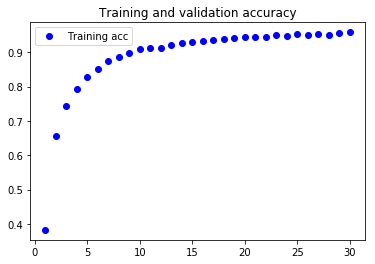

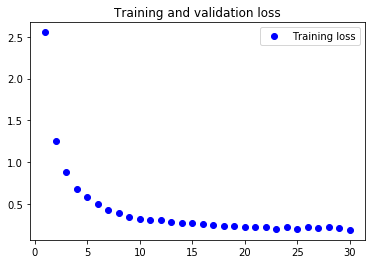

In [47]:
acc = history.history['acc']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [50]:
model.save('flower_vgg16_noDataAugmentation.h5')

### Load Model

In [51]:
model = load_model('flower_vgg16_noDataAugmentation.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 102)               26214     
Total params: 2,123,622
Trainable params: 2,123,622
Non-trainable params: 0
_________________________________________________________________


In [62]:
test_data =  pd.read_csv('test.csv')
test_data['category'] = test_data['category'].astype(str)
test_data['image_id'] = test_data['image_id'].astype(str).apply(append_ext)
test_data['image_id'] = test_data['image_id'].astype(str)
test_data.head()

,image_id,category
0,18540.jpg,nan
1,18541.jpg,nan
2,18542.jpg,nan
3,18543.jpg,nan
4,18544.jpg,nan


In [63]:
test_features, test_labels = extract_features(test_data, 2009)

Found 2009 validated image filenames belonging to 1 classes.


In [64]:
test_features =  np.reshape(test_features,  (2009, 4*4* 512))

In [72]:
prediction = model.predict_classes(test_features)
prediction

array([43, 77,  1, ..., 54, 77, 99], dtype=int64)

In [66]:
sample = pd.read_csv('sample_submission.csv')

In [67]:
sample.head()

,image_id,category
0,18540,0
1,18541,0
2,18542,0
3,18543,0
4,18544,0


In [68]:
sample['category'] = prediction

In [70]:
sample.head()

,image_id,category
0,18540,43
1,18541,77
2,18542,1
3,18543,71
4,18544,72


In [71]:
sample.to_csv('sample_submission_VGG16.csv', header=True, index=False)

## Resnet Kaggle

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
import json

In [6]:
train = pd.read_csv('train.csv')
train.head()

,image_id,category
0,0,77
1,1,81
2,2,52
3,3,72
4,4,58


In [7]:
labels = len(set(train['category']))
resnet_weights_path = 'resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [9]:
train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('train/'+train['image_id'][i].astype('str')+'.jpg', target_size=(224,224,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|████████████████████████████████████████████████████████████████████████████| 18540/18540 [04:02<00:00, 76.39it/s]


In [88]:
y = train['category'].values.reshape(-1, 1)
onehot_encoder = OneHotEncoder(sparse=False)
y = onehot_encoder.fit_transform(y)
y.shape

C:\Users\shadow\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(18540, 102)

In [45]:
def create_model_from_ResNet50():

    model = Sequential()
    model.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(103, activation='softmax'))

    model.layers[0].trainable = False
    sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return model

In [46]:
model_ResNet50 = create_model_from_ResNet50()
model_ResNet50.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 103)               26471     
Total params: 24,138,727
Trainable params: 551,015
Non-trainable params: 23,587,712
_________________________________________________________________


In [54]:
image_size = 224

data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

train_generator = data_generator.flow(
    X,
    y,
    batch_size=24,
)

validation_generator = data_generator.flow(
    X,
    y,
    batch_size=24,
)

In [55]:
NUM_EPOCHS = 30
EARLY_STOP_PATIENCE = 5

In [56]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '.bestResnet.h5',
                                  monitor = 'val_loss',
                                  save_best_only = True,
                                  mode = 'auto')

In [58]:
history = model_ResNet50.fit_generator(
    train_generator,
    steps_per_epoch=10,
    validation_data=validation_generator,
    validation_steps=10,
    epochs=NUM_EPOCHS,
    callbacks=[cb_checkpointer, cb_early_stopper])

Epoch 1/30
10/10 [==============================] - ETA: 2:21 - loss: 5.0111 - acc: 0.0000e+0 - ETA: 1:47 - loss: 5.1503 - acc: 0.0000e+0 - ETA: 1:28 - loss: 5.1518 - acc: 0.0000e+0 - ETA: 1:13 - loss: 5.0653 - acc: 0.0208    - ETA: 1:00 - loss: 5.0272 - acc: 0.016 - ETA: 47s - loss: 5.0291 - acc: 0.013 - ETA: 35s - loss: 5.0626 - acc: 0.01 - ETA: 23s - loss: 5.0378 - acc: 0.01 - ETA: 11s - loss: 5.0372 - acc: 0.01 - 150s 15s/step - loss: 5.0295 - acc: 0.0125 - val_loss: 4.7163 - val_acc: 0.0000e+00
Epoch 2/30
10/10 [==============================] - ETA: 1:40 - loss: 5.0981 - acc: 0.041 - ETA: 1:28 - loss: 5.0418 - acc: 0.020 - ETA: 1:17 - loss: 5.1055 - acc: 0.013 - ETA: 1:06 - loss: 4.9613 - acc: 0.010 - ETA: 55s - loss: 4.9164 - acc: 0.008 - ETA: 44s - loss: 4.8655 - acc: 0.00 - ETA: 33s - loss: 4.8258 - acc: 0.00 - ETA: 22s - loss: 4.8037 - acc: 0.01 - ETA: 10s - loss: 4.7893 - acc: 0.00 - 142s 14s/step - loss: 4.7743 - acc: 0.0125 - val_loss: 4.6587 - val_acc: 0.0417
Epoch 3/30
 

KeyboardInterrupt: 

In [90]:
import keras
keras.__version__

'2.2.4'